In [6]:
%matplotlib inline

import os
import time

import IPython.display as ipd
import numpy as np
import pandas as pd
import seaborn as sns

import utils

from matplotlib import pyplot
from sklearn.model_selection import train_test_split, KFold

#from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import auc, plot_roc_curve

In [7]:
# Custom options for visualization
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [8]:
# Loading Data

tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features_df = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

In [9]:
# Splitting Data between rows with genre_top set and unset

tracks_genres_info = tracks['track'][['genre_top', 'genres', 'genres_all']] 
tracks_genres_info['track_id'] = tracks_genres_info.index

null_top_genre_mask_mask = tracks_genres_info.genre_top.isnull()

null_top_genre_tracks_df = tracks_genres_info.loc[null_top_genre_mask_mask,:]
not_null_top_genre_tracks_df = tracks_genres_info.loc[~null_top_genre_mask_mask,:]

In [10]:
# Expanding genres and genres_all column as a str

def transform_genres_list_to_str(genres_list):
    return "|".join([str(x) for x in genres_list])

null_top_genre_tracks_df['genres_str'] = null_top_genre_tracks_df.genres.apply(transform_genres_list_to_str)
null_top_genre_tracks_df['genres_all_str'] = null_top_genre_tracks_df.genres_all.apply(transform_genres_list_to_str)

_df = null_top_genre_tracks_df.set_index('track_id').genres_str.str.split('|', expand=True).stack()

_df

/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


track_id   
20        0     76
          1    103
26        0     76
          1    103
30        0     76
              ... 
155278    1    107
155288    0       
155320    0     10
          1     12
          2    169
Length: 169266, dtype: object

In [11]:
def choosing_top_genre(genres_list, genres_df, target_genres): 
    for genre_id in genres_list:
        return target_genres[genres_df.loc[genre_id,'top_level']]            
    return np.NaN

In [12]:
target_genres = dict(zip(list(genres[(genres.parent == 0)].index), list(genres[(genres.parent == 0)].title)))

null_top_genre_tracks_df['derived_genre_top'] = null_top_genre_tracks_df.genres.apply(choosing_top_genre, args=(genres,target_genres))

(~null_top_genre_tracks_df.isnull()).sum()

/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


genre_top                0
genres               56976
genres_all           56976
track_id             56976
genres_str           56976
genres_all_str       56976
derived_genre_top    54745
dtype: int64

In [13]:
original_genre_top_mask = (tracks_genres_info.genre_top == 'Hip-Hop') | (tracks_genres_info.genre_top == 'Pop') | (tracks_genres_info.genre_top == 'Rock') | (tracks_genres_info.genre_top == 'Blues')  | (tracks_genres_info.genre_top == 'Jazz')
print(tracks_genres_info[original_genre_top_mask].shape)

#tracks_genres_info['derived_genre_top'] = null_top_genre_tracks_df.derived_genre_top

(20747, 4)


In [14]:
null_top_genre_tracks_df.derived_genre_top.value_counts()

Electronic             15674
Experimental           12116
Rock                    7100
Pop                     5683
Folk                    3280
Instrumental            2288
Jazz                    1722
Blues                   1566
International           1535
Hip-Hop                  982
Classical                872
Soul-RnB                 745
Country                  532
Spoken                   345
Old-Time / Historic      156
Easy Listening           149
Name: derived_genre_top, dtype: int64

In [15]:
# Adding derived to a new DF

tracks_info_with_derived_top_genre_df = tracks_genres_info.copy()
tracks_info_with_derived_top_genre_df["_genre_top"] = ''

_df = null_top_genre_tracks_df[~null_top_genre_tracks_df.derived_genre_top.isnull()]

for index, row in tracks_genres_info.iterrows():
    if isinstance(row.genre_top, str) or (~np.isnan(row.genre_top)):
        tracks_info_with_derived_top_genre_df.at[index, '_genre_top'] = row.genre_top
    elif index in _df.index:
        tracks_info_with_derived_top_genre_df.at[index, '_genre_top'] = _df.at[index,'derived_genre_top']

In [16]:
tracks_info_with_derived_top_genre_df['duration'] = tracks.track['duration']
tracks_info_with_derived_top_genre_df['genre_top'] = tracks_info_with_derived_top_genre_df._genre_top

print((~tracks_info_with_derived_top_genre_df.genre_top.isnull()).sum())
print((~tracks_info_with_derived_top_genre_df._genre_top.isnull()).sum())

106574
106574


In [17]:
track_ids_genre_not_null_and_echonest = list(set(echonest.echonest.audio_features.index) & set(not_null_top_genre_tracks_df.index))
track_ids_derived_genre_and_echonest = list(set(echonest.echonest.audio_features.index) & set(null_top_genre_tracks_df.index))

print(len(track_ids_genre_not_null_and_echonest), len(track_ids_derived_genre_and_echonest))

9355 3774


In [18]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'tempo', 'duration']

In [19]:
original_genre_fetures_df = pd.concat([echonest.echonest.audio_features[echonest.index.isin(track_ids_genre_not_null_and_echonest)], tracks[tracks.index.isin(track_ids_genre_not_null_and_echonest)].track[['genre_top', 'duration']]], 1)
original_genre_fetures_df.head()

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
2             0.416675      0.675894  0.634476          0.010628  0.177647   
3             0.374408      0.528643  0.817461          0.001851  0.105880   
5             0.043567      0.745566  0.701470          0.000697  0.373143   
10            0.951670      0.658179  0.924525          0.965427  0.115474   
134           0.452217      0.513238  0.560410          0.019443  0.096567   

          speechiness    tempo   valence genre_top  duration  
track_id                                                      
2            0.159310  165.922  0.576661   Hip-Hop       168  
3            0.461818  126.957  0.269240   Hip-Hop       237  
5            0.124595  100.260  0.621661   Hip-Hop       206  
10           0.032985  111.562  0.963590       Pop       161  
134          0.525519  114.290  0.894072   Hip-Hop       207

In [20]:
derived_genre_fetures_df = pd.concat([echonest.echonest.audio_features[echonest.index.isin(track_ids_derived_genre_and_echonest)], tracks_info_with_derived_top_genre_df[tracks_info_with_derived_top_genre_df.index.isin(track_ids_derived_genre_and_echonest)][['genre_top', 'duration']]], 1)
derived_genre_fetures_df.head()

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
236           0.230013      0.848918  0.444921          0.820067  0.162606   
461           0.984355      0.571168  0.319628          0.030623  0.567914   
462           0.983755      0.648854  0.273137          0.258233  0.665152   
463           0.987198      0.694961  0.309419          0.340356  0.102491   
464           0.978804      0.618105  0.381706          0.609562  0.100077   

          speechiness    tempo   valence   genre_top  duration  
track_id                                                        
236          0.101744  120.095  0.846313  Electronic       309  
461          0.050290  107.232  0.788501       Blues       328  
462          0.033117  115.764  0.517182       Blues       323  
463          0.039797  115.397  0.554299       Blues       224  
464          0.067830  114.829  0.622699       Blues       397

In [1474]:
# Add extra technical features to dataset


_features = ["chroma_cens", "chroma_cqt", "chroma_stft", "mfcc", "rmse", "spectral_bandwidth", "spectral_contrast", "spectral_rolloff", "tonnetz", "zcr"]
_fields = ["kurtosis", "mean", "std", "median", "max", "min"]

# Collecting only the needed rows for both datasets
audio_features_df  = features_df[features_df.index.isin(list(original_genre_fetures_df.index) + list(derived_genre_fetures_df.index))][_features]

# Flatten features

tracks_with_extra_audio_features_df = pd.DataFrame(index=audio_features_df.index)

## Initializing all needed columns with NaN
for index, row in audio_features_df.head(1).iterrows():
    for feature in _features:
        for field in _fields:
            i = 0
            for k in row[feature][field]: # channel (if it is channel ?)                
                i += 1
                tracks_with_extra_audio_features_df[f'{feature}_{field[0:3]}_{i}'] = np.nan

# Populating each row with audio analysis feature values
start = time.time()
_count = 0
for index, row in audio_features_df.iterrows():
    _count += 1
    for feature in _features:
        for field in _fields:
            i = 0
            for k in row[feature][field]: # channel (if it is channel ?)                
                i += 1
                tracks_with_extra_audio_features_df.at[index, f'{feature}_{field[0:3]}_{i}'] = k                
    if _count % 1000 == 0:
        print(_count, f'{time.time() - start}')
stop = time.time()

print(f"Extending data took: {stop - start}s")



1000 31.933099031448364
2000 63.88125681877136
3000 100.82996773719788
4000 137.6189088821411
5000 170.53327989578247
6000 203.6897008419037
7000 240.12894797325134
8000 275.1192877292633
9000 309.2279736995697
10000 342.2327060699463
11000 376.10208678245544
12000 410.2850649356842
13000 443.21559977531433
Extending data took: 447.65509390830994s


In [ ]:
print(tracks_with_extra_audio_features_df.shape)
tracks_with_extra_audio_features_df

In [1476]:
extra_audio_genre_df = pd.concat([original_genre_fetures_df, tracks_with_extra_audio_features_df[tracks_with_extra_audio_features_df.index.isin(original_genre_fetures_df.index)]], 1)
extra_audio_derived_genre_df = pd.concat([derived_genre_fetures_df, tracks_with_extra_audio_features_df[tracks_with_extra_audio_features_df.index.isin(derived_genre_fetures_df.index)]], 1)

print(extra_audio_genre_df.shape, extra_audio_derived_genre_df.shape)

(9355, 448) (3774, 448)


<AxesSubplot:xlabel='genre_top', ylabel='count'>

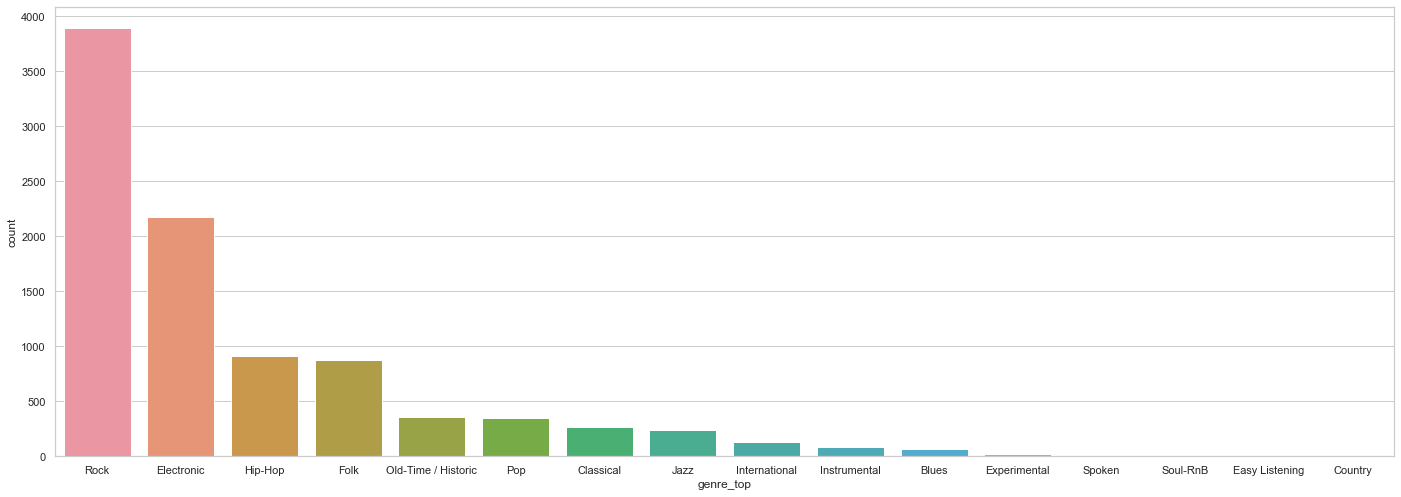

In [1447]:
a4_dims = (24, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.countplot(x='genre_top', data=extra_audio_genre_df, order = original_genre_fetures_df['genre_top'].value_counts().index)

In [1448]:
extra_audio_genre_df.shape

(9355, 448)

In [26]:
original_genre_data = basic_data_preparation(original_genre_fetures_df, features=original_genre_fetures_df.drop('genre_top', axis=1).columns)
derived_genre_data = basic_data_preparation(derived_genre_fetures_df, features=original_genre_fetures_df.drop('genre_top', axis=1).columns)

original_genre_data_audio_features = basic_data_preparation(extra_audio_genre_df, features=extra_audio_genre_df.drop('genre_top', axis=1).columns)
derived_genre_data_audio_features = basic_data_preparation(extra_audio_derived_genre_df, features=extra_audio_derived_genre_df.drop('genre_top', axis=1).columns)

original_genre_data['y_train'].value_counts()

Rock                   2919
Electronic             1627
Hip-Hop                 682
Folk                    655
Old-Time / Historic     268
Pop                     259
Classical               199
Jazz                    181
International           100
Instrumental             63
Blues                    50
Experimental             13
Spoken                    0
Soul-RnB                  0
Easy Listening            0
Country                   0
Name: genre_top, dtype: int64

In [27]:
original_genre_data['X_train_rs'], original_genre_data['y_train_rs'] = resampling(original_genre_data['X_train'], original_genre_data['y_train'])
original_genre_data['X_train_rs'], original_genre_data['y_train_rs'] = resampling(original_genre_data['X_train'], original_genre_data['y_train'])

original_genre_data_audio_features['X_train_rs'], original_genre_data_audio_features['y_train_rs'] = resampling(original_genre_data_audio_features['X_train'], original_genre_data_audio_features['y_train'])
# derived_genre_data_audio_features['X_train_rs'], derived_genre_data_audio_features['y_train_rs'] = resampling(derived_genre_data_audio_features['X_train'], derived_genre_data_audio_features['y_train'])

In [334]:
def test_model_cv_grid(x_train, y_train, x_test, y_test, model, params, cv_splits=3, score='recall_macro', sample_weight=None, verbose=False):
    if verbose:
        print(y_train)   
        print(type(y_train))
        print(type(y_train[0]))
    
    oredered_genres = list(y_train.unique())
    oredered_genres.sort()
    
    cv_Stratified_KFold = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=105)
    model_ht = GridSearchCV(model, params, n_jobs=-1, cv = cv_Stratified_KFold, verbose=3, scoring=score)
    start = time.time()
    model_ht.fit(x_train, y_train, sample_weight=sample_weight)
    stop = time.time()
    print(f"Training time: {stop - start}s")
    
    y_pred = model_ht.predict(x_test)
    print(f'accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'f1_score: {f1_score(y_test, y_pred, average="macro")}')
    print(f'precision: {precision_score(y_test, y_pred, average="macro")}')
    print(f'recall: {recall_score(y_test, y_pred, average="macro")}') 
    print(model_ht.best_params_)
    custom_plot_confusion_matrix(confusion_matrix(y_test[y_test.isin(oredered_genres)], y_pred[y_test.isin(oredered_genres)]), genre_list=oredered_genres)
    print(classification_report(y_test[y_test.isin(oredered_genres)], y_pred[y_test.isin(oredered_genres)]))

    return model_ht

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   14.0s remaining:   56.1s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   19.6s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   30.7s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   32.8s finished


Training time: 40.12272834777832s
accuracy: 0.6259085079093629
f1_score: 0.41256117065650283
precision: 0.484833316682189
recall: 0.42246268149125
{'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 500}
                     precision    recall  f1-score   support

              Blues       1.00      0.06      0.12        16
          Classical       0.70      0.79      0.74        66
         Electronic       0.58      0.71      0.64       543
       Experimental       0.00      0.00      0.00         4
               Folk       0.38      0.63      0.48       219
            Hip-Hop       0.67      0.71      0.69       228
       Instrumental       0.00      0.00      0.00        21
      International       0.33      0.27      0.30        33
               Jazz       0.32      0.22      0.26        60
Old-Time / Historic       0.83      0.92      0.87        89
                Pop       0.22      0.13      0.16        87
               Rock       0.80      0.63      0.70   

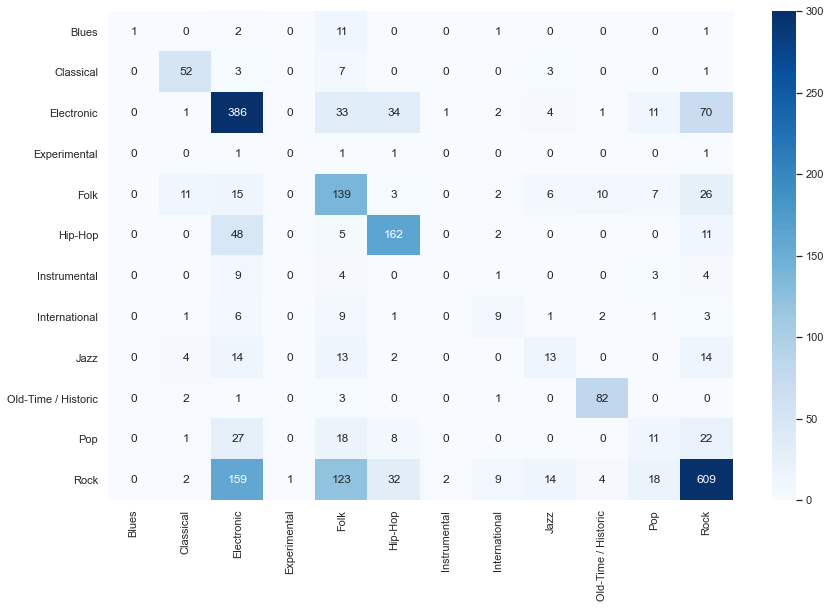

In [313]:
model = test_model_cv_grid(
    original_genre_data['X_train_rs'], 
    original_genre_data['y_train_rs'], 
    original_genre_data['X_test'], 
    original_genre_data['y_test'], 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': [15, 20], 
        'n_estimators': [500, 700], 
        'class_weight': ['balanced']
    },
    cv_splits=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   22.8s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   31.5s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   48.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   50.9s finished


Training time: 65.86445498466492s
accuracy: 0.6472851646002565
f1_score: 0.3734819096353319
precision: 0.4931374923238076
recall: 0.3801473463252864
{'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 700}


/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

              Blues       1.00      0.06      0.12        16
          Classical       0.65      0.59      0.62        66
         Electronic       0.66      0.62      0.64       543
       Experimental       0.00      0.00      0.00         4
               Folk       0.41      0.48      0.44       219
            Hip-Hop       0.72      0.68      0.70       228
       Instrumental       0.00      0.00      0.00        21
      International       0.67      0.18      0.29        33
               Jazz       0.35      0.12      0.17        60
Old-Time / Historic       0.51      0.99      0.67        89
                Pop       0.24      0.05      0.08        87
               Rock       0.72      0.79      0.75       973

           accuracy                           0.65      2339
          macro avg       0.49      0.38      0.37      2339
       weighted avg       0.63      0.65      0.63      2339



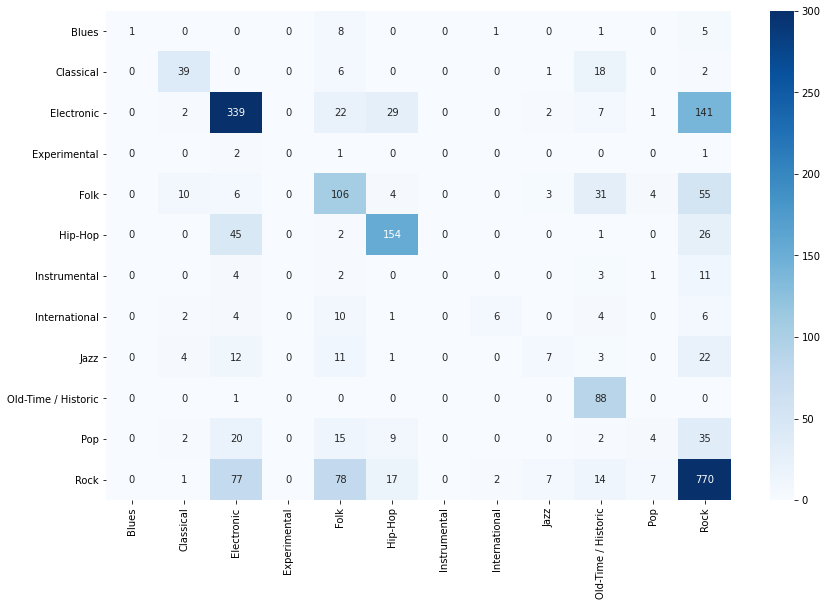

In [309]:
model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs'], 
    original_genre_data_audio_features['y_train_rs'], 
    original_genre_data_audio_features['X_test'], 
    original_genre_data_audio_features['y_test'], 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': [15, 20], 
        'n_estimators': [500, 700], 
        'class_weight': ['balanced']
    },
    cv_splits=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  2.0min remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished


Training time: 194.5041778087616s
accuracy: 0.735356990166738
f1_score: 0.5121414368728398
precision: 0.6570870390942285
recall: 0.49196350841526076
{'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 500}


/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

              Blues       1.00      0.25      0.40        16
          Classical       0.81      0.85      0.83        66
         Electronic       0.68      0.80      0.74       543
       Experimental       0.00      0.00      0.00         4
               Folk       0.48      0.82      0.61       219
            Hip-Hop       0.74      0.70      0.72       228
       Instrumental       0.00      0.00      0.00        21
      International       1.00      0.39      0.57        33
               Jazz       0.75      0.25      0.38        60
Old-Time / Historic       0.94      0.98      0.96        89
                Pop       0.64      0.08      0.14        87
               Rock       0.84      0.79      0.82       973

           accuracy                           0.74      2339
          macro avg       0.66      0.49      0.51      2339
       weighted avg       0.75      0.74      0.72      2339



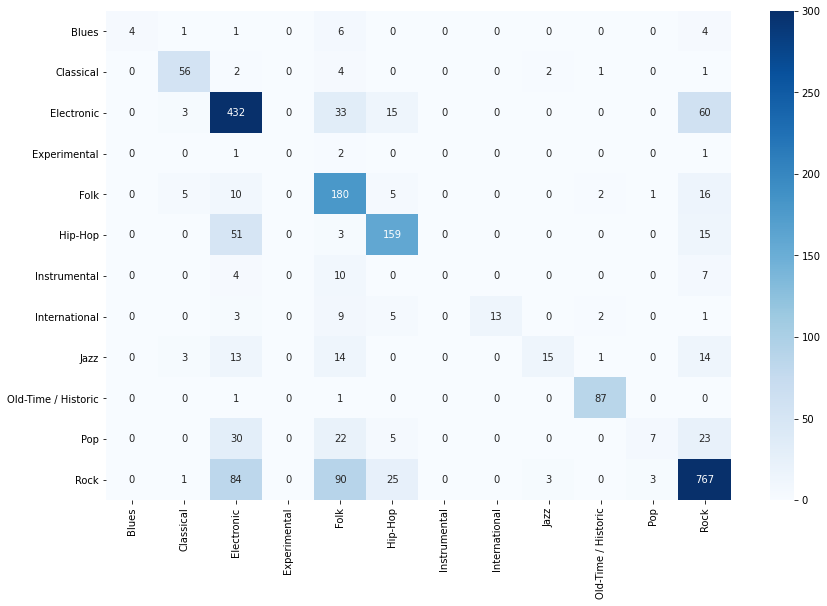

In [552]:
model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs'].drop('duration', axis=1), 
    original_genre_data_audio_features['y_train_rs'], 
    original_genre_data_audio_features['X_test'].drop('duration', axis=1),
    original_genre_data_audio_features['y_test'], 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': [10, 15], 
        'n_estimators': [100, 500], 
        'class_weight': ['balanced'],
        'min_samples_split': np.linspace(1,7, 2, dtype='int'),
        'min_samples_leaf': np.linspace(1,4, 1, dtype='int'),
    },
    cv_splits=5)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:  4.4min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:  8.0min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  9.1min finished


Training time: 583.9474098682404s
accuracy: 0.4365113296280462
f1_score: 0.12622848833961411
precision: 0.23017295329066878
recall: 0.15256327393903749
{'estimator__C': 100, 'estimator__class_weight': 'balanced', 'estimator__kernel': 'poly'}


/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

              Blues       0.07      0.12      0.09        16
          Classical       0.00      0.00      0.00        66
         Electronic       0.73      0.20      0.32       543
       Experimental       0.00      0.00      0.00         4
               Folk       0.29      0.01      0.02       219
            Hip-Hop       0.81      0.11      0.19       228
       Instrumental       0.03      0.29      0.06        21
      International       0.00      0.00      0.00        33
               Jazz       0.07      0.13      0.09        60
Old-Time / Historic       0.00      0.00      0.00        89
                Pop       0.29      0.08      0.13        87
               Rock       0.48      0.88      0.62       973

           accuracy                           0.44      2339
          macro avg       0.23      0.15      0.13      2339
       weighted avg       0.49      0.44      0.36      2339



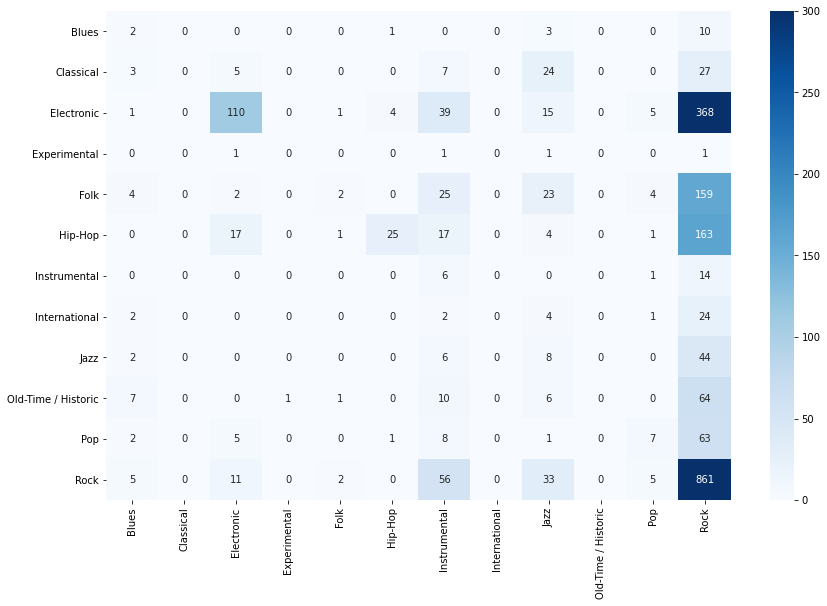

In [340]:
from sklearn.multiclass import OneVsOneClassifier

model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs'].drop('duration', axis=1), 
    original_genre_data_audio_features['y_train_rs'], 
    original_genre_data_audio_features['X_test'].drop('duration', axis=1),
    original_genre_data_audio_features['y_test'], 
    OneVsOneClassifier(svm.SVC(random_state=7)), 
    {
        'estimator__C': [10, 100], 
        'estimator__kernel': ['poly', 'rbf', 'linear'], 
        'estimator__class_weight': ['balanced']
    },
    cv_splits=4)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Training time: 2.2705740928649902s
accuracy: 0.4023086789226165
f1_score: 0.2595827980507887
precision: 0.2760368060308353
recall: 0.29435883585738404
{}
                     precision    recall  f1-score   support

              Blues       0.04      0.19      0.06        16
          Classical       0.27      0.70      0.38        66
         Electronic       0.63      0.47      0.54       543
       Experimental       0.00      0.00      0.00         4
               Folk       0.29      0.20      0.24       219
            Hip-Hop       0.55      0.55      0.55       228
       Instrumental       0.02      0.05      0.02        21
      International       0.05      0.18      0.08        33
               Jazz       0.05      0.15      0.07        60
Old-Time / Historic       0.53      0.53      0.53        89
                Pop       0.09      0.11      0.10        87
               Rock       0.80      0.40      0.54       973

           accuracy                           0.40 

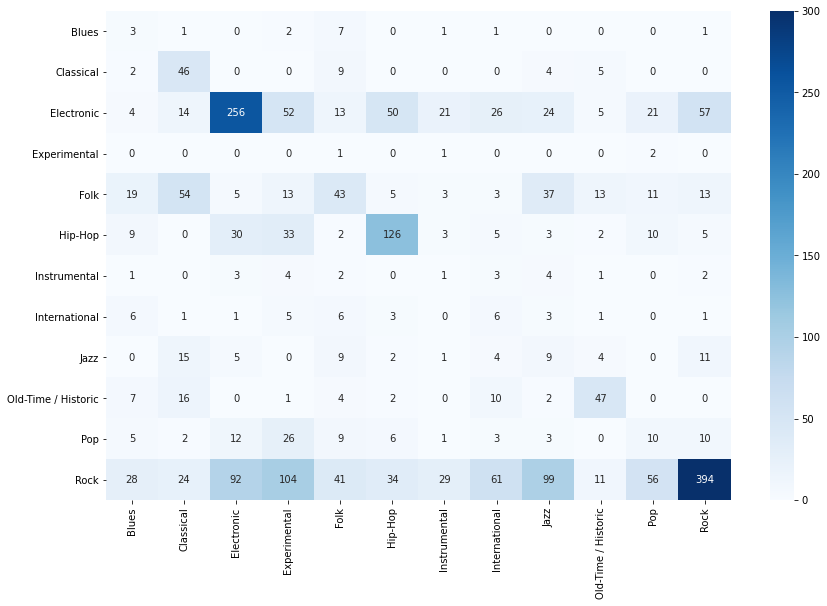

In [350]:
from sklearn.neighbors import NearestCentroid

model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs'].drop('duration', axis=1), 
    original_genre_data_audio_features['y_train_rs'], 
    original_genre_data_audio_features['X_test'].drop('duration', axis=1),
    original_genre_data_audio_features['y_test'], 
    NearestCentroid(), {},
    cv_splits=5)

In [734]:
## Menos géneros y menos columnas

_genres_to_study = ['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic']

_features_to_study = ['mfcc', 'rmse', 'spectral_bandwidth', 'chroma_cens']

features_to_study = []
for col in list(original_genre_data_audio_features['X_train_rs'].columns):
    for filt in _features_to_study:
        if col.startswith(filt):
            features_to_study.append(col)

In [735]:
X_train_reduced = original_genre_data_audio_features['X_train_rs'][original_genre_data_audio_features['y_train_rs'].isin(_genres_to_study)]
Y_train_reduced = original_genre_data_audio_features['y_train_rs'][original_genre_data_audio_features['y_train_rs'].isin(_genres_to_study)]

print(X_train_reduced.shape, Y_train_reduced.shape)
Y_train_reduced.index

(4139, 447) (4139,)


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247],
           dtype='int64', length=4139)

In [736]:
#original_genre_data_audio_features['y_test'] = original_genre_data_audio_features['y_test'].reset_index()

X_test_reduced = original_genre_data_audio_features['X_test'][list(original_genre_data_audio_features['y_test'].genre_top.isin(_genres_to_study))]
Y_test_reduced = original_genre_data_audio_features['y_test'][list(original_genre_data_audio_features['y_test'].genre_top.isin(_genres_to_study))]

print(X_test_reduced.shape, Y_test_reduced.shape)
Y_test_reduced.genre_top.value_counts()

(1672, 447) (1672, 4)


Rock                   973
Hip-Hop                228
Folk                   219
Old-Time / Historic     89
Classical               66
Jazz                    60
Instrumental            21
Blues                   16
Spoken                   0
Soul-RnB                 0
Pop                      0
International            0
Experimental             0
Electronic               0
Easy Listening           0
Country                  0
Name: genre_top, dtype: int64

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed: 15.3min remaining:   31.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 15.3min finished


Training time: 1008.1192960739136s
accuracy: 0.741769987174006
f1_score: 0.5232571263285294
precision: 0.7575765877083155
recall: 0.49743428080887003
{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 600}


/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

              Blues       1.00      0.25      0.40        16
          Classical       0.76      0.83      0.80        66
         Electronic       0.68      0.80      0.73       543
       Experimental       0.00      0.00      0.00         4
               Folk       0.50      0.82      0.62       219
            Hip-Hop       0.79      0.66      0.72       228
       Instrumental       1.00      0.05      0.09        21
      International       1.00      0.42      0.60        33
               Jazz       0.70      0.27      0.39        60
Old-Time / Historic       0.95      0.98      0.96        89
                Pop       0.88      0.08      0.15        87
               Rock       0.84      0.81      0.82       973

           accuracy                           0.74      2339
          macro avg       0.76      0.50      0.52      2339
       weighted avg       0.77      0.74      0.73      2339



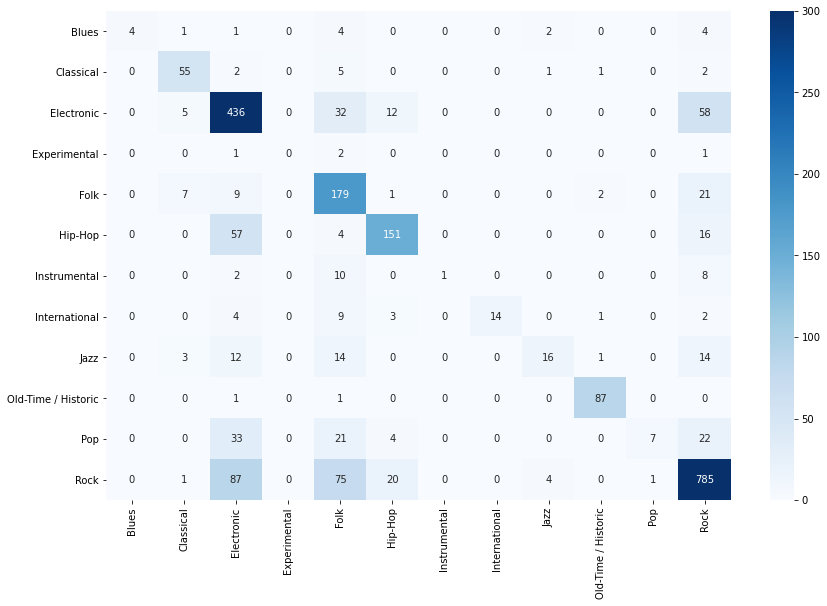

In [553]:
model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs'].drop('duration', axis=1), 
    original_genre_data_audio_features['y_train_rs'], 
    original_genre_data_audio_features['X_test'].drop('duration', axis=1),
    original_genre_data_audio_features['y_test'], 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': np.linspace(10,20, 2, dtype='int'),
        'n_estimators': [400, 500, 600], 
        'class_weight': ['balanced'],
        'min_samples_split': np.linspace(4,12, 2, dtype='int'),
        'min_samples_leaf': np.linspace(1,2, 1, dtype='int'),
    },
    cv_splits=5)

In [737]:
# PCA

# Aplicando Reducción de dimensionalidad (PCA

pca = PCA(n_components = 0.95, random_state=7)

#X_train_rs_sc_ea,y_train_rs_sc_ea
original_genre_data_audio_features['X_train_rs_pca'] = pca.fit_transform(original_genre_data_audio_features['X_train_rs'])
original_genre_data_audio_features['X_test_pca'] = pca.transform(original_genre_data_audio_features['X_test'])

original_genre_data_audio_features['X_train_rs_pca_reduced'] = pca.fit_transform(X_train_reduced)
original_genre_data_audio_features['X_test_pca_reduced'] = pca.transform(X_test_reduced)

original_genre_data_audio_features['y_train_rs_reduced'] = Y_train_reduced
original_genre_data_audio_features['y_test_reduced'] = Y_test_reduced

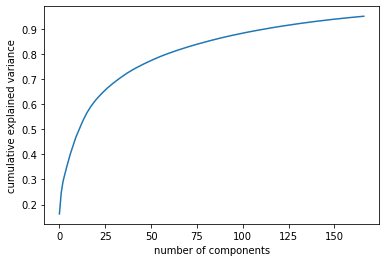

In [738]:
pyplot.plot(np.cumsum(pca.explained_variance_ratio_))
pyplot.xlabel('number of components')
pyplot.ylabel('cumulative explained variance');

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  1.2min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  2.5min remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.5min finished


Training time: 201.2856833934784s
accuracy: 0.7101325352714836
f1_score: 0.47039522486815954
precision: 0.7708927050561601
recall: 0.4425670641425972
{'class_weight': 'balanced', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 600}


/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

              Blues       1.00      0.19      0.32        16
          Classical       0.89      0.74      0.81        66
         Electronic       0.63      0.77      0.69       543
       Experimental       0.00      0.00      0.00         4
               Folk       0.48      0.73      0.58       219
            Hip-Hop       0.73      0.61      0.67       228
       Instrumental       1.00      0.05      0.09        21
      International       1.00      0.21      0.35        33
               Jazz       0.75      0.20      0.32        60
Old-Time / Historic       0.97      0.99      0.98        89
                Pop       1.00      0.02      0.04        87
               Rock       0.80      0.81      0.80       973

           accuracy                           0.71      2339
          macro avg       0.77      0.44      0.47      2339
       weighted avg       0.74      0.71      0.69      2339



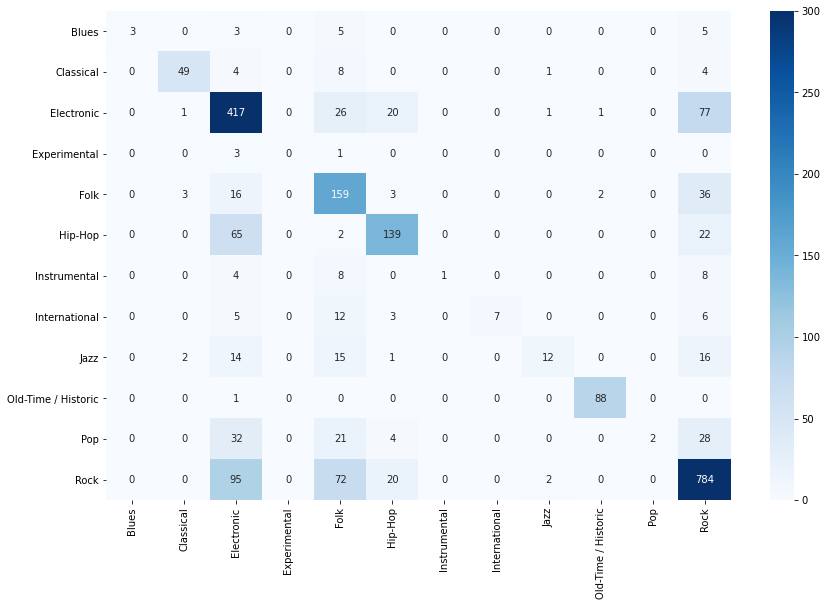

In [577]:
model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs_pca'], 
    original_genre_data_audio_features['y_train_rs'], 
    original_genre_data_audio_features['X_test_pca'],
    original_genre_data_audio_features['y_test'], 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': np.linspace(19,20, 2, dtype='int'),
        'n_estimators': [600], 
        'class_weight': ['balanced'],
        'min_samples_split': np.linspace(11, 12, 2, dtype='int'),
        'min_samples_leaf': [1],
    },
    cv_splits=5)

In [649]:
print(original_genre_data_audio_features['X_train_rs_pca_reduced'].shape, original_genre_data_audio_features['y_train_rs_reduced'].shape)
print(original_genre_data_audio_features['X_test_pca_reduced'].shape, original_genre_data_audio_features['y_test_reduced'].genre_top.shape)

(4839, 168) (4839,)
(1672, 168) (1672,)


In [650]:
model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs_pca_reduced'], 
    original_genre_data_audio_features['y_train_rs_reduced'], 
    original_genre_data_audio_features['X_test_pca_reduced'],
    original_genre_data_audio_features['y_test_reduced'].genre_top, 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': np.linspace(24,30, 2, dtype='int'),
        'n_estimators': [650,700, 750], 
        'class_weight': ['balanced'],
        'min_samples_split': np.linspace(8,12, 2, dtype='int'),
        'min_samples_leaf': [1]
    },
    cv_splits=5, score='roc_auc_ovo_weighted')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:  4.7min remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.8min finished


Training time: 320.7519600391388s
accuracy: 0.7978468899521531
f1_score: 0.5474988207582927
precision: 0.8979306649922858
recall: 0.5106244877327656
{'class_weight': 'balanced', 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 750}
                     precision    recall  f1-score   support

              Blues       1.00      0.06      0.12        16
          Classical       0.98      0.67      0.79        66
               Folk       0.68      0.64      0.66       219
            Hip-Hop       0.79      0.67      0.73       228
       Instrumental       1.00      0.05      0.09        21
               Jazz       1.00      0.10      0.18        60
Old-Time / Historic       0.93      0.97      0.95        89
               Rock       0.80      0.93      0.86       973

           accuracy                           0.80      1672
          macro avg       0.90      0.51      0.55      1672
       weighted avg       0.81      0.80      0.78      1672



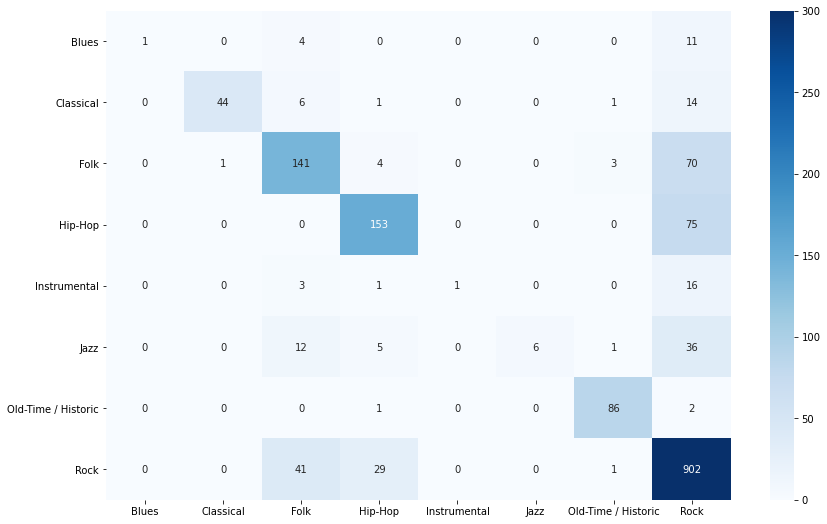

In [654]:
model.score(original_genre_data_audio_features['X_train_rs_pca_reduced'], original_genre_data_audio_features['y_train_rs_reduced'])

0.9235212640491473

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.3min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.3min remaining:   58.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 152.2160439491272s
accuracy: 0.7577751196172249
f1_score: 0.48841107516953686
precision: 0.5699633587233612
recall: 0.4741420328046396
{'colsample_bynode': 0.4, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 1.0}


/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00        16
          Classical       0.85      0.61      0.71        66
               Folk       0.57      0.56      0.56       219
            Hip-Hop       0.69      0.68      0.68       228
       Instrumental       0.00      0.00      0.00        21
               Jazz       0.78      0.12      0.20        60
Old-Time / Historic       0.88      0.96      0.91        89
               Rock       0.79      0.88      0.84       973

           accuracy                           0.76      1672
          macro avg       0.57      0.47      0.49      1672
       weighted avg       0.74      0.76      0.74      1672



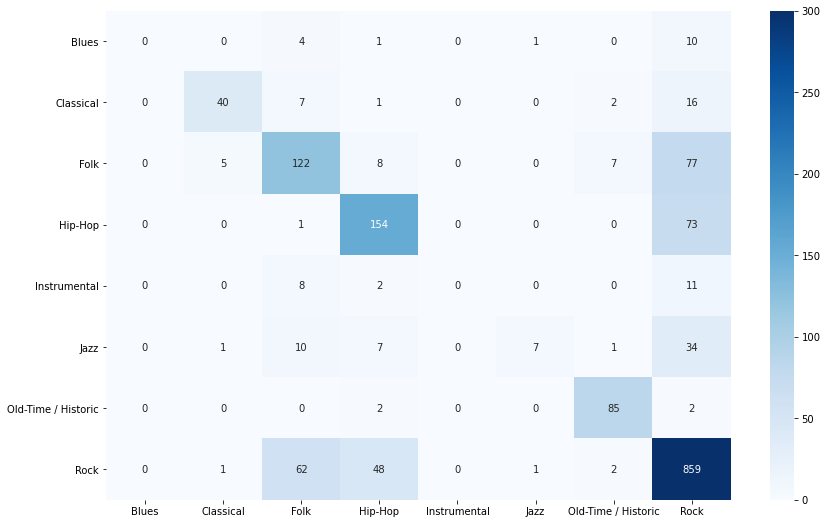

In [655]:
from  xgboost import XGBRFClassifier

gridSearch_params = {
                     'n_estimators': [500],
                     'max_depth': [3],
                     'learning_rate': [0.1],
                     'min_child_weight': [4,5],
                     'subsample': [1.0],
                     'colsample_bytree': [0.6],
                     'colsample_bynode': [0.4]
                    }

model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs_pca_reduced'], 
    original_genre_data_audio_features['y_train_rs_reduced'], 
    original_genre_data_audio_features['X_test_pca_reduced'],
    original_genre_data_audio_features['y_test_reduced'].genre_top, 
    XGBRFClassifier(random_state=7), 
    gridSearch_params,
    cv_splits=5, score='roc_auc_ovo_weighted')

In [656]:
model.score(original_genre_data_audio_features['X_train_rs_pca_reduced'], original_genre_data_audio_features['y_train_rs_reduced'])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  4.4min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  5.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.2min finished
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:19:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 358.90321826934814s
accuracy: 0.7529904306220095
f1_score: 0.485863585160846
precision: 0.5698085768398269
recall: 0.46939802035722245
{'colsample_bynode': 0.4, 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 1.0}


/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00        16
          Classical       0.84      0.56      0.67        66
               Folk       0.55      0.57      0.56       219
            Hip-Hop       0.69      0.66      0.67       228
       Instrumental       0.00      0.00      0.00        21
               Jazz       0.80      0.13      0.23        60
Old-Time / Historic       0.89      0.96      0.92        89
               Rock       0.79      0.88      0.83       973

           accuracy                           0.75      1672
          macro avg       0.57      0.47      0.49      1672
       weighted avg       0.74      0.75      0.73      1672



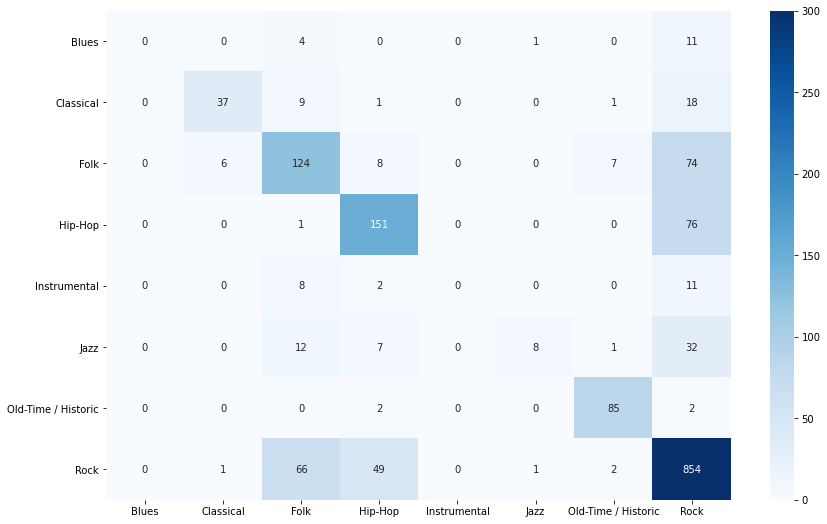

In [659]:
from  xgboost import XGBRFClassifier

gridSearch_params = {
                     'n_estimators': [750, 1000],
                     'max_depth': [3],
                     'learning_rate': [0.01],
                     'min_child_weight': [5],
                     'subsample': [1.0],
                     'colsample_bytree': [0.6],
                     'colsample_bynode': [0.4]
                    }

model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs_pca_reduced'], 
    original_genre_data_audio_features['y_train_rs_reduced'], 
    original_genre_data_audio_features['X_test_pca_reduced'],
    original_genre_data_audio_features['y_test_reduced'].genre_top, 
    XGBRFClassifier(random_state=7), 
    gridSearch_params,
    cv_splits=5, score='roc_auc_ovo_weighted')

In [688]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(original_genre_data_audio_features['y_train_rs_reduced']),
                                             original_genre_data_audio_features['y_train_rs_reduced']))

w_array = np.ones(original_genre_data_audio_features['y_train_rs_reduced'].shape[0], dtype = 'float')
for i, val in enumerate(original_genre_data_audio_features['y_train_rs_reduced']):
    w_array[i] = class_weights[_t[val]]

w_array

array([4.0325    , 4.0325    , 4.0325    , ..., 1.28696809, 1.28696809,
       1.28696809])

In [684]:
cc = pd.Categorical(original_genre_data_audio_features['y_train_rs_reduced'].unique())

_t = dict(zip(np.unique(original_genre_data_audio_features['y_train_rs_reduced']), [x for x in range(8)]))

print(dict(zip(np.unique(original_genre_data_audio_features['y_train_rs_reduced']), [x for x in range(8)])))
print(cc)

{'Blues': 0, 'Classical': 1, 'Folk': 2, 'Hip-Hop': 3, 'Instrumental': 4, 'Jazz': 5, 'Old-Time / Historic': 6, 'Rock': 7}
[Blues, Classical, Folk, Hip-Hop, Instrumental, Jazz, Old-Time / Historic, Rock]
Categories (8, object): [Blues, Classical, Folk, Hip-Hop, Instrumental, Jazz, Old-Time / Historic, Rock]


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 229.739511013031s
accuracy: 0.680622009569378
f1_score: 0.5358074091018574
precision: 0.5011677886834363
recall: 0.6039876192461511
{'colsample_bynode': 0.4, 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 1.0}
                     precision    recall  f1-score   support

              Blues       0.36      0.31      0.33        16
          Classical       0.60      0.76      0.67        66
               Folk       0.50      0.61      0.55       219
            Hip-Hop       0.56      0.82      0.67       228
       Instrumental       0.10      0.24      0.14        21
               Jazz       0.27      0.45      0.34

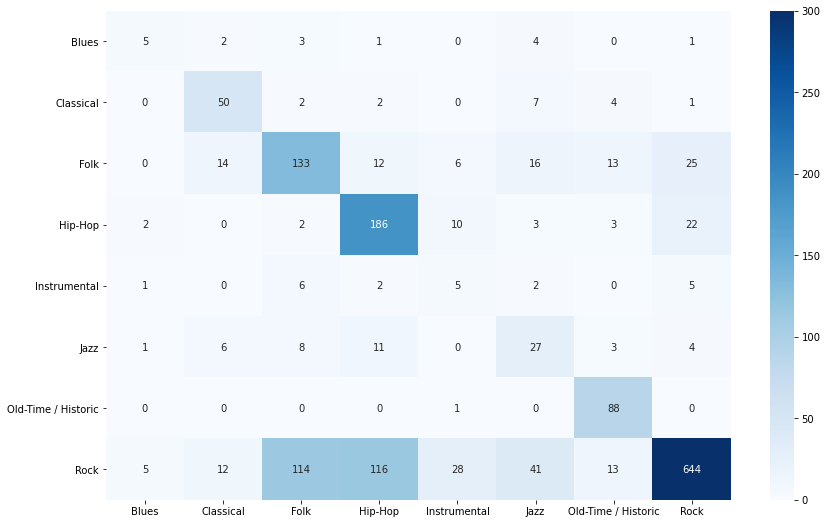

In [695]:
from  xgboost import XGBRFClassifier

gridSearch_params = {
                     'n_estimators': [1000],
                     'max_depth': [3],
                     'learning_rate': [0.01],
                     'min_child_weight': [5],
                     'subsample': [1.0],
                     'colsample_bytree': [0.6],
                     'colsample_bynode': [0.4]
                    }

model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs_pca_reduced'], 
    original_genre_data_audio_features['y_train_rs_reduced'], 
    original_genre_data_audio_features['X_test_pca_reduced'],
    original_genre_data_audio_features['y_test_reduced'].genre_top, 
    XGBRFClassifier(random_state=7), 
    gridSearch_params,
    cv_splits=5, score='roc_auc_ovo_weighted', sample_weight=w_array)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   42.5s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   45.5s remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Training time: 97.08708620071411s
accuracy: 0.7990430622009569
f1_score: 0.554690154575205
precision: 0.8984136157312973
recall: 0.5156269486522593
{'class_weight': 'balanced_subsample', 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 750}
                     precision    recall  f1-score   support

              Blues       1.00      0.06      0.12        16
          Classical       1.00      0.68      0.81        66
               Folk       0.67      0.63      0.65       219
            Hip-Hop       0.79      0.68      0.73       228
       Instrumental       1.00      0.05      0.09        21
               Jazz       1.00      0.13      0.24        60
Old-Time / Historic       0.91      0.97      0.94        89
               Rock       0.80      0.93      0.86       973

           accuracy                           0.80      1672
          macro avg       0.90      0.52      0.55      1672
       weighted avg       0.81      0.80      0.78     

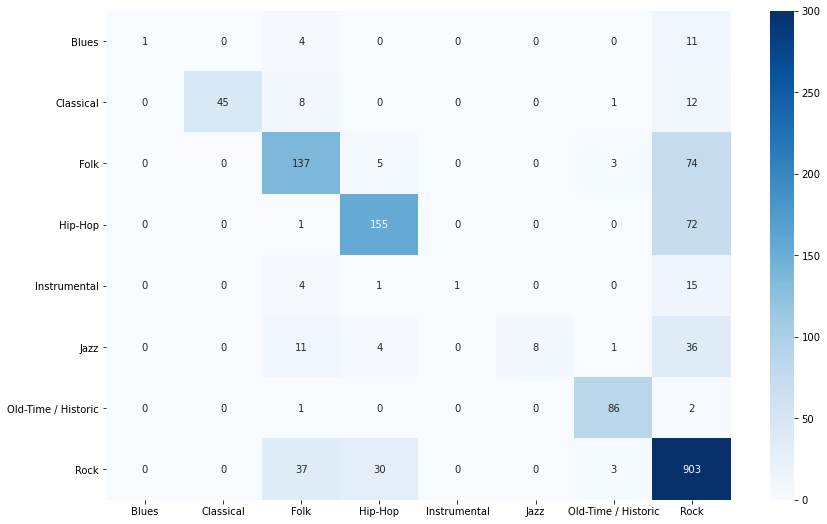

In [706]:
model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs_pca_reduced'], 
    original_genre_data_audio_features['y_train_rs_reduced'], 
    original_genre_data_audio_features['X_test_pca_reduced'],
    original_genre_data_audio_features['y_test_reduced'].genre_top, 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': [24],
        'n_estimators': [750], 
        'class_weight': ['balanced_subsample'],
        'min_samples_split': [8],
        'min_samples_leaf': [1]
    },
    cv_splits=5, score='roc_auc_ovo_weighted')

In [709]:
best_model = model

model.score(original_genre_data_audio_features['X_train_rs_pca_reduced'], original_genre_data_audio_features['y_train_rs_reduced'])

0.9999997181055381

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 21.4min finished


Training time: 1342.6434478759766s
accuracy: 0.7984449760765551
f1_score: 0.5536033242343785
precision: 0.8981697118126702
recall: 0.5141753168603791
{'ccp_alpha': 0.0001, 'class_weight': 'balanced_subsample', 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1000}
                     precision    recall  f1-score   support

              Blues       1.00      0.06      0.12        16
          Classical       1.00      0.67      0.80        66
               Folk       0.67      0.63      0.65       219
            Hip-Hop       0.79      0.68      0.73       228
       Instrumental       1.00      0.05      0.09        21
               Jazz       1.00      0.13      0.24        60
Old-Time / Historic       0.92      0.97      0.95        89
               Rock       0.80      0.93      0.86       973

           accuracy                           0.80      1672
          macro avg       0.90      0.51      0.55      1672
       weighted avg       0.81 

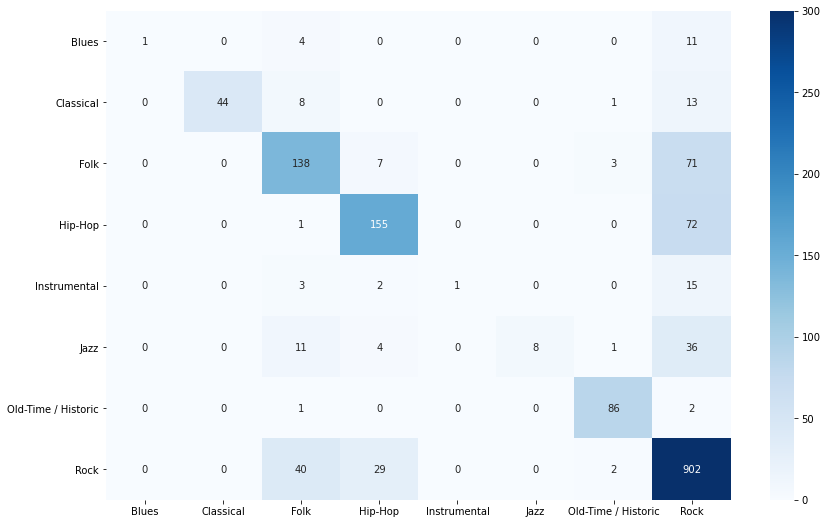

In [713]:
model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs_pca_reduced'], 
    original_genre_data_audio_features['y_train_rs_reduced'], 
    original_genre_data_audio_features['X_test_pca_reduced'],
    original_genre_data_audio_features['y_test_reduced'].genre_top, 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': [24],
        'n_estimators': [1000], 
        'class_weight': ['balanced_subsample'],
        'min_samples_split': [8],
        'min_samples_leaf': [1],
        'ccp_alpha': [0.001],
        'oob_score': [True]
    },
    cv_splits=3, score='roc_auc_ovo_weighted')

In [714]:
best_model = model

model.score(original_genre_data_audio_features['X_train_rs_pca_reduced'], original_genre_data_audio_features['y_train_rs_reduced'])

0.9999993080772296

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.1s remaining:   34.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished


Training time: 50.54323196411133s
accuracy: 0.7715311004784688
f1_score: 0.5728515609292901
precision: 0.8501544180737328
recall: 0.5508384424865085
{'class_weight': 'balanced_subsample', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 800, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.12      0.22        16
          Classical       0.98      0.73      0.83        66
               Folk       0.52      0.75      0.62       219
            Hip-Hop       0.67      0.78      0.72       228
       Instrumental       1.00      0.05      0.09        21
               Jazz       0.86      0.20      0.32        60
Old-Time / Historic       0.91      0.96      0.93        89
               Rock       0.86      0.82      0.84       973

           accuracy                           0.77      1672
          macro avg       0.85      0.55      0.57      1672
       weighted avg       0.80     

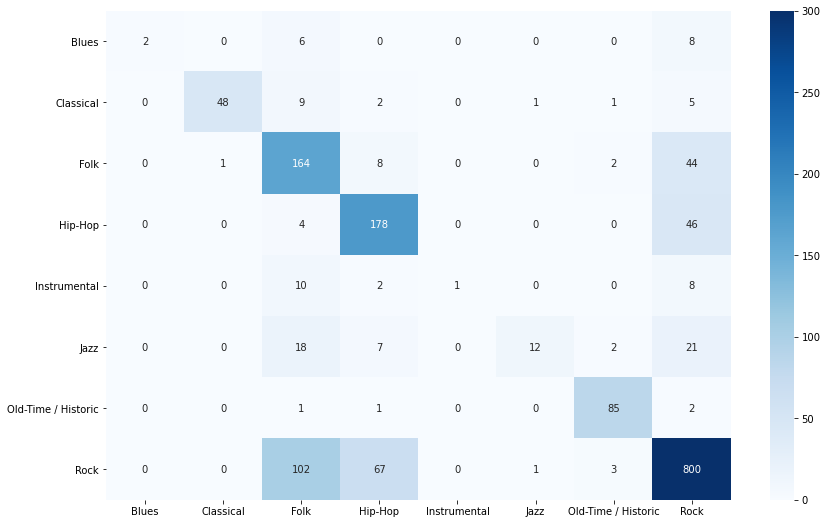

In [729]:
model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs_pca_reduced'], 
    original_genre_data_audio_features['y_train_rs_reduced'], 
    original_genre_data_audio_features['X_test_pca_reduced'],
    original_genre_data_audio_features['y_test_reduced'].genre_top, 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': [12],
        'n_estimators': [800], 
        'class_weight': ['balanced_subsample'],
        'min_samples_split': [8],
        'min_samples_leaf': [1],
#        'ccp_alpha': [0.003, 0.002,0.004],
        'oob_score': [True]
    },
    cv_splits=5, score='roc_auc_ovo_weighted')

In [730]:
model.score(original_genre_data_audio_features['X_train_rs_pca_reduced'], original_genre_data_audio_features['y_train_rs_reduced'])

0.9997159929552074

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 30.2min finished


Training time: 1835.7490422725677s
accuracy: 0.77811004784689
f1_score: 0.6434740545550555
precision: 0.7866823830261283
recall: 0.6321281522834985
{'class_weight': 'balanced_subsample', 'max_depth': 24, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 1000}
                     precision    recall  f1-score   support

              Blues       1.00      0.38      0.55        16
          Classical       0.76      0.80      0.78        66
               Folk       0.50      0.72      0.59       219
            Hip-Hop       0.70      0.89      0.78       228
       Instrumental       1.00      0.14      0.25        21
               Jazz       0.58      0.37      0.45        60
Old-Time / Historic       0.85      0.97      0.91        89
               Rock       0.91      0.79      0.85       973

           accuracy                           0.78      1672
          macro avg       0.79      0.63      0.64      1672
       weighted avg       0.81      0.78      0.78   

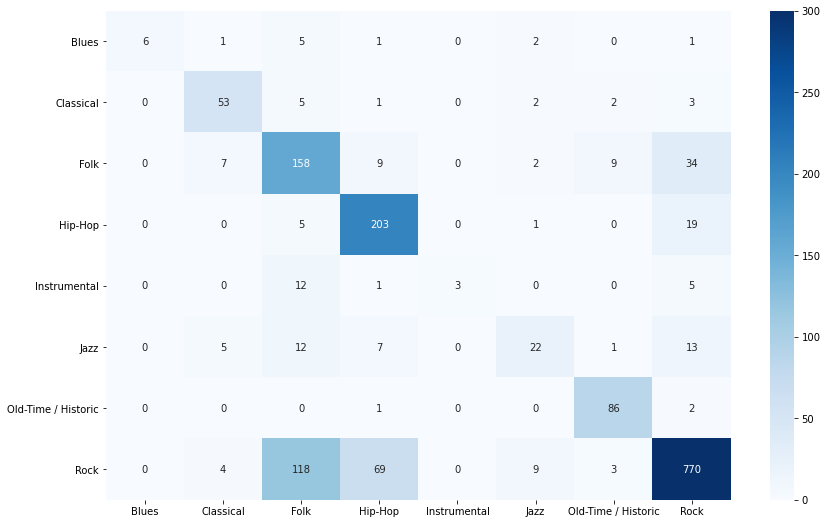

In [746]:
model = test_model_cv_grid(
    original_genre_data_audio_features['X_train_rs_pca_reduced'], 
    original_genre_data_audio_features['y_train_rs_reduced'], 
    original_genre_data_audio_features['X_test_pca_reduced'],
    original_genre_data_audio_features['y_test_reduced'].genre_top, 
    RandomForestClassifier(random_state=7), 
    {
        'max_depth': [12, 16, 20, 24],
        'n_estimators': [750, 850, 1000], 
        'class_weight': ['balanced_subsample'],
        'min_samples_split': [6, 8, 12],
        'min_samples_leaf': [10,12,14,16,20],
#        'ccp_alpha': [0.001],
#        'oob_score': [True]
    },
    cv_splits=3, score='roc_auc_ovo_weighted')

In [747]:
model.score(original_genre_data_audio_features['X_train_rs_pca_reduced'], original_genre_data_audio_features['y_train_rs_reduced'])
# Visualizar y Limpiar un poco el dataset de entrenamiento de los features principales ( outliers duration, mfcc, etc )

0.9979296595762387

In [598]:
# Completar con canciones de las recuperadas para las clases minoritarias (programaticamente)

0                     Blues
1                     Blues
2                     Blues
3                     Blues
4                     Blues
               ...         
6243    Old-Time / Historic
6244    Old-Time / Historic
6245    Old-Time / Historic
6246    Old-Time / Historic
6247    Old-Time / Historic
Name: genre_top, Length: 4139, dtype: category
Categories (16, object): [Blues, Classical, Country, Easy Listening, ..., Pop, Rock, Soul-RnB, Spoken]

In [307]:
# Changing Scaler Strategy

def test_scaling(data, 
                 scaler, 
                 pca_components=None, 
                 random_state=7, 
                 _genres_to_study = [],
                 sample_weight=False,
                 params={},
                 cv_splits=3,
                 verbose=False
                ):

    # Data Scaling and Split    
    data = basic_data_preparation(extra_audio_genre_df, scaler_class=scaler, features=extra_audio_genre_df.drop('genre_top', axis=1).columns)

    # Resampling
    X_train, y_train = resampling(data['X_train'], data['y_train'])
   
    X_test = data['X_test']
    y_test = data['y_test']
    
    # Genre Filters
    if _genres_to_study:
        X_train = X_train[y_train.isin(_genres_to_study)]
        y_train = y_train[y_train.isin(_genres_to_study)]
        
        X_test = X_test[y_test.reset_index().genre_top.isin(_genres_to_study)]
        y_test = y_test[y_test.isin(_genres_to_study)].reset_index().genre_top

    # PCA 
    if pca_components:

        pca = PCA(n_components = pca_components, random_state=random_state)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
                          
    # Class Weights
    sample_weights = None
    if sample_weight:
        class_weights = list(class_weight.compute_class_weight('balanced',
                                                                np.unique(y_train),
                                                                y_train
                                                              )
                            )

        w_array = np.ones(y_train.shape[0], dtype = 'float')
        for i, val in enumerate(y_train):
            w_array[i] = class_weights[_t[val]]
        print(w_array)
        sample_weights = w_array


        
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    # Agregar flag para hacer fit o para dibujar resultados (dado un model ya fiteado/instanciado)
    if versbose:
        print(y_train)
    model = test_model_cv_grid(
        X_train, 
        y_train, 
        X_test,
        y_test, 
        RandomForestClassifier(random_state=random_state), 
        params,
        cv_splits=cv_splits, 
        score='roc_auc_ovo_weighted', 
        sample_weight=sample_weights)
    
    # Decouple Printing results from test_model_cv_grid
    # Add to results training score
    # Optional curves
    
    #print(f'Train Score: ')
    return model

    

(4139, 447) (4139,)
(1672, 447) (1672,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.4s remaining:   44.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.6s finished


Training time: 62.295729875564575s
accuracy: 0.8026315789473685
f1_score: 0.6078281061635578
precision: 0.8243541688720772
recall: 0.6086550750105442
{'class_weight': 'balanced_subsample', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 800, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.12      0.22        16
          Classical       0.85      0.86      0.86        66
               Folk       0.54      0.86      0.66       219
            Hip-Hop       0.71      0.87      0.78       228
       Instrumental       1.00      0.05      0.09        21
               Jazz       0.61      0.32      0.42        60
Old-Time / Historic       0.96      0.98      0.97        89
               Rock       0.93      0.81      0.87       973

           accuracy                           0.80      1672
          macro avg       0.82      0.61      0.61      1672
       weighted avg       0.84    

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=105, shuffle=True),
             estimator=RandomForestClassifier(random_state=7), n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample'],
                         'max_depth': [12], 'min_samples_leaf': [1],
                         'min_samples_split': [8], 'n_estimators': [800],
                         'oob_score': [True]},
             scoring='roc_auc_ovo_weighted', verbose=3)

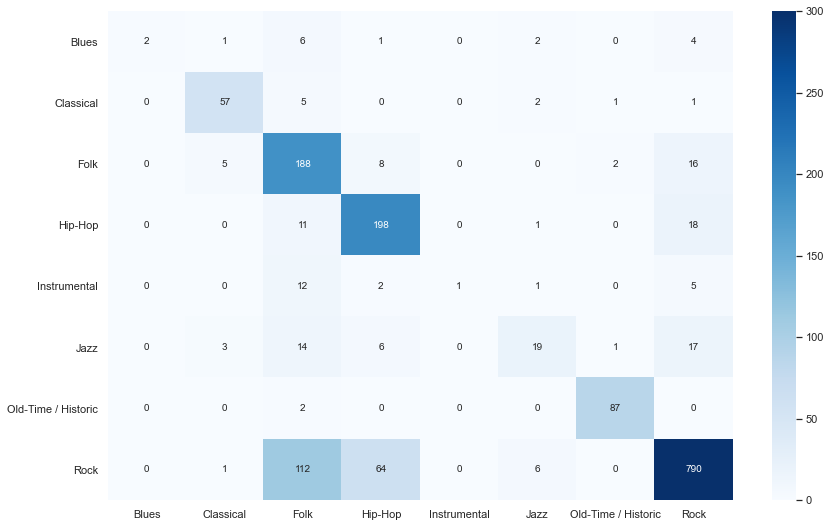

In [36]:
test_scaling(
             tracks_with_extra_audio_features_df, 
             RobustScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,
             params={
                    'max_depth': [12],
                    'n_estimators': [800], 
                    'class_weight': ['balanced_subsample'],
                    'min_samples_split': [8],
                    'min_samples_leaf': [1],
            #        'ccp_alpha': [0.003, 0.002,0.004],
                    'oob_score': [True]
                }
            )

In [ ]:
extra_audio_genre_df.head()

(4139, 447) (4139,)
(1672, 447) (1672,)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 84.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 137.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 308.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 467.9min finished


Training time: 28243.951596021652s
accuracy: 0.7900717703349283
f1_score: 0.6691691157139121
precision: 0.7329209075962515
recall: 0.6678865932617997
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 1000}
                     precision    recall  f1-score   support

              Blues       1.00      0.44      0.61        16
          Classical       0.74      0.86      0.80        66
               Folk       0.56      0.79      0.65       219
            Hip-Hop       0.67      0.90      0.77       228
       Instrumental       0.62      0.24      0.34        21
               Jazz       0.43      0.35      0.39        60
Old-Time / Historic       0.91      0.98      0.94        89
               Rock       0.94      0.79      0.85       973

           accuracy                           0.79      1672
          macro avg       0.73      0.67      0.67      1672
       weighted avg       0.82      0.79      0.79 

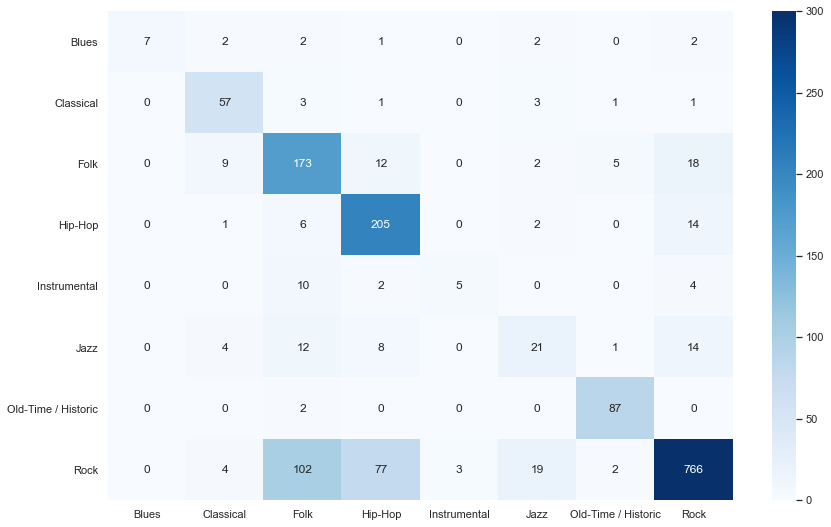

In [79]:
# Robust Scaler exploration without CCP Alpha, PCA nor OOB

model_1 = test_scaling_2(
             tracks_with_extra_audio_features_df, 
             RobustScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [12, 16, 20, 24],
                'n_estimators': [750, 850, 1000], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6, 8, 12],
                'min_samples_leaf': [10,12,14,16,20],
        #        'ccp_alpha': [0.001],
        #        'oob_score': [True]
             },
             cv_splits=5
        )

(4139, 447) (4139,)
(1672, 447) (1672,)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 114.7min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 259.5min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 309.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 331.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 339.8min finished


Training time: 20426.996800899506s
accuracy: 0.7930622009569378
f1_score: 0.6751031875798027
precision: 0.7437889329024137
recall: 0.669651766624846
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.44      0.61        16
          Classical       0.79      0.83      0.81        66
               Folk       0.56      0.83      0.67       219
            Hip-Hop       0.67      0.89      0.76       228
       Instrumental       0.62      0.24      0.34        21
               Jazz       0.47      0.37      0.41        60
Old-Time / Historic       0.91      0.98      0.94        89
               Rock       0.94      0.79      0.86       973

           accuracy                           0.79      1672
          macro avg       0.74      0.67      0.68      1672
       weighted avg       0.82   

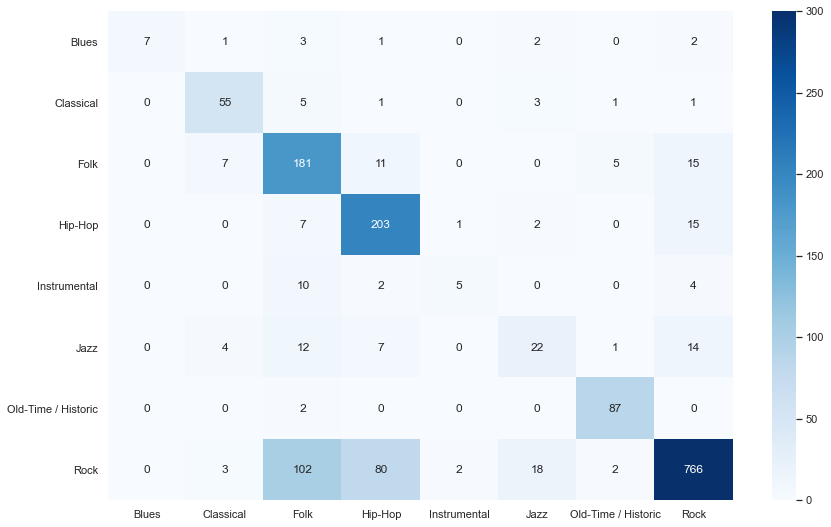

In [80]:
## Same as model 1 but with OOB True

model_2 = test_scaling_2(
             tracks_with_extra_audio_features_df, 
             RobustScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [12, 16, 20, 24],
                'n_estimators': [750, 850, 1000], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6, 8, 12],
                'min_samples_leaf': [10,12,14,16,20],
                'oob_score': [True]
             },
             cv_splits=5
        )

mode.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


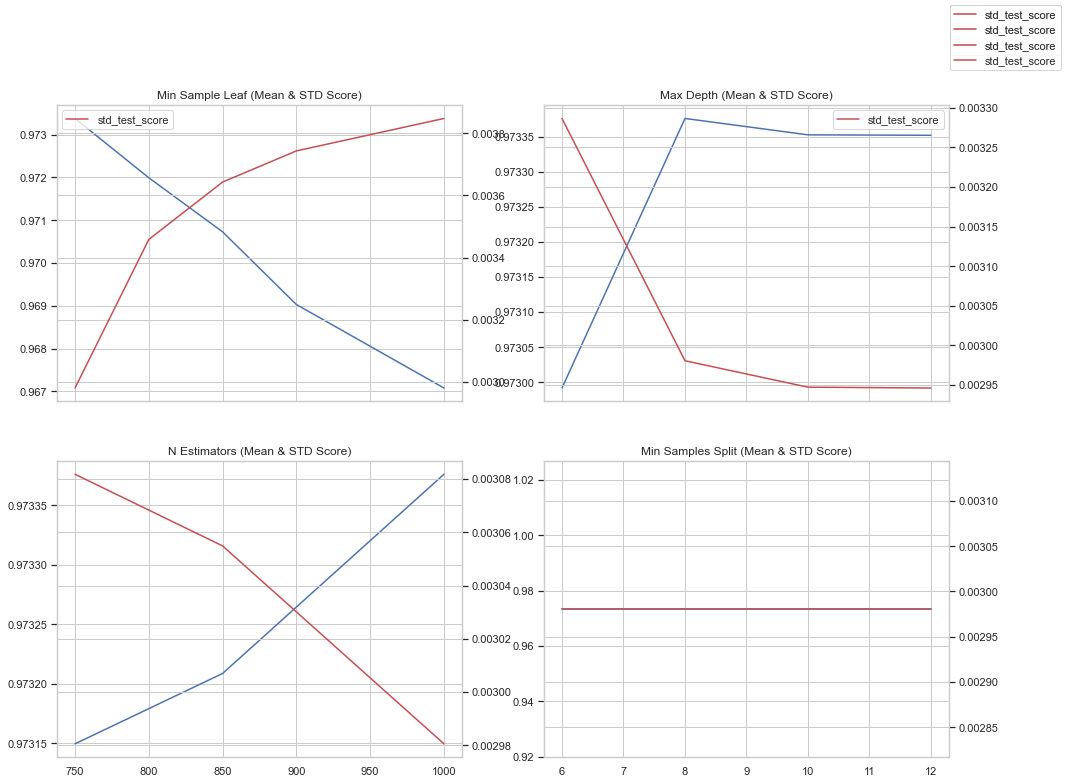

model.param_grid
{'max_depth': [12, 16, 20, 24], 'n_estimators': [750, 850, 1000], 'class_weight': ['balanced_subsample'], 'min_samples_split': [6, 8, 12], 'min_samples_leaf': [10, 12, 14, 16, 20], 'oob_score': [True]}
model.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


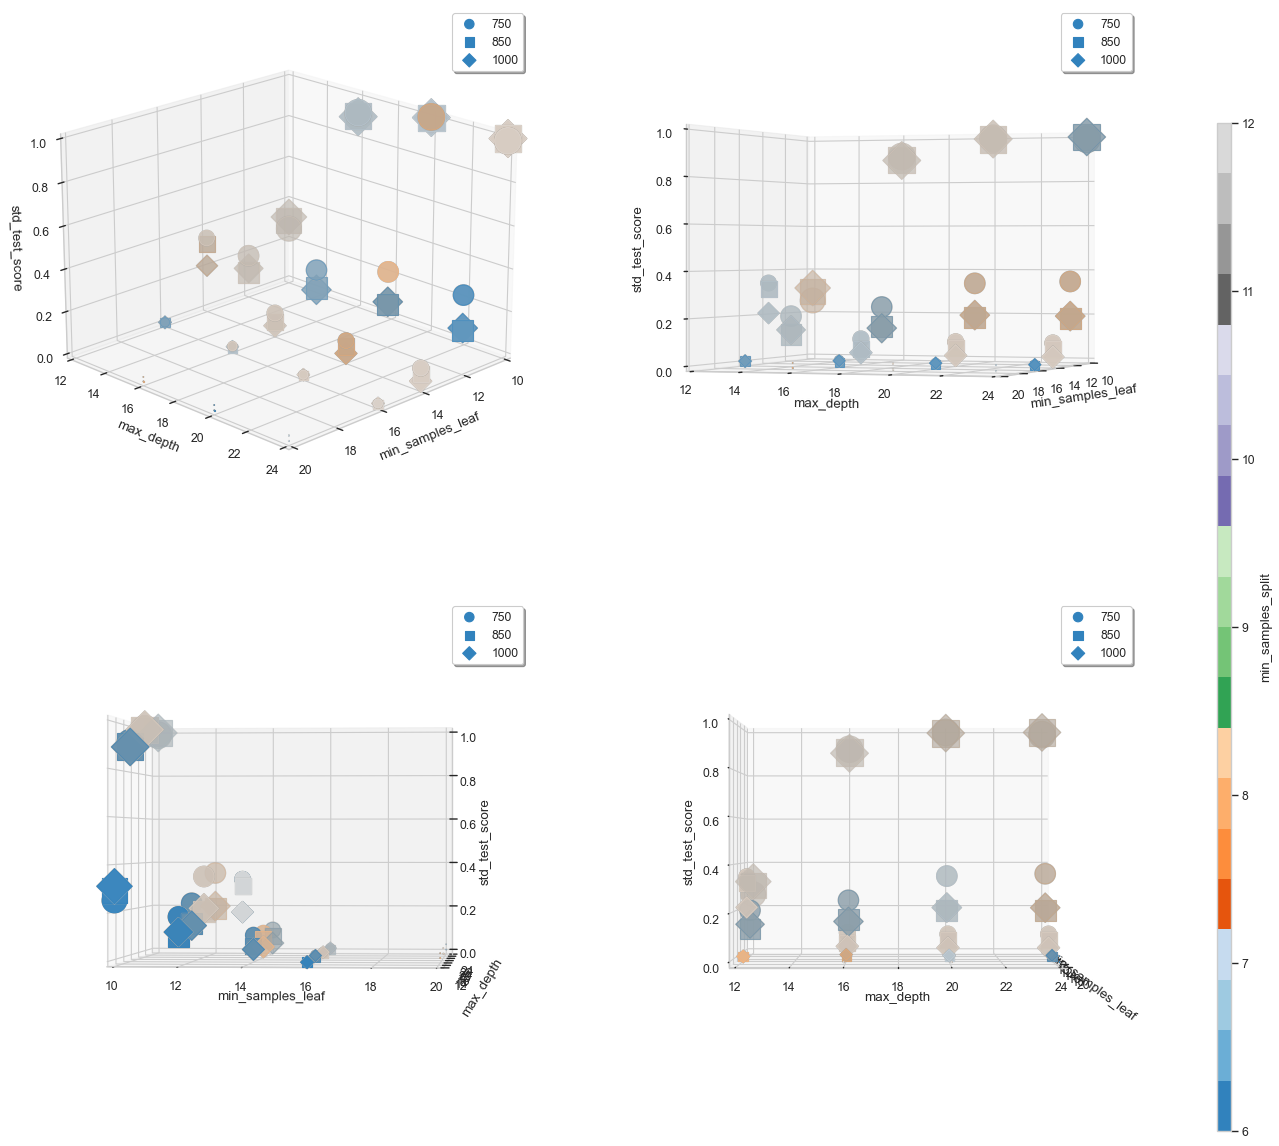

In [848]:
graph_training(model_2[0])
make_3d_plots(model_2[0])

(4139, 447) (4139,)
(1672, 447) (1672,)
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 33.3min finished


Training time: 2029.50896692276s
accuracy: 0.8074162679425837
f1_score: 0.6397227455574818
precision: 0.7721873645525975
recall: 0.63246785670777
{'class_weight': 'balanced_subsample', 'max_depth': 24, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 750}
                     precision    recall  f1-score   support

              Blues       1.00      0.25      0.40        16
          Classical       0.83      0.83      0.83        66
               Folk       0.56      0.85      0.67       219
            Hip-Hop       0.72      0.89      0.80       228
       Instrumental       0.67      0.10      0.17        21
               Jazz       0.53      0.35      0.42        60
Old-Time / Historic       0.95      0.98      0.96        89
               Rock       0.93      0.81      0.87       973

           accuracy                           0.81      1672
          macro avg       0.77      0.63      0.64      1672
       weighted avg       0.83      0.81      0.81      1

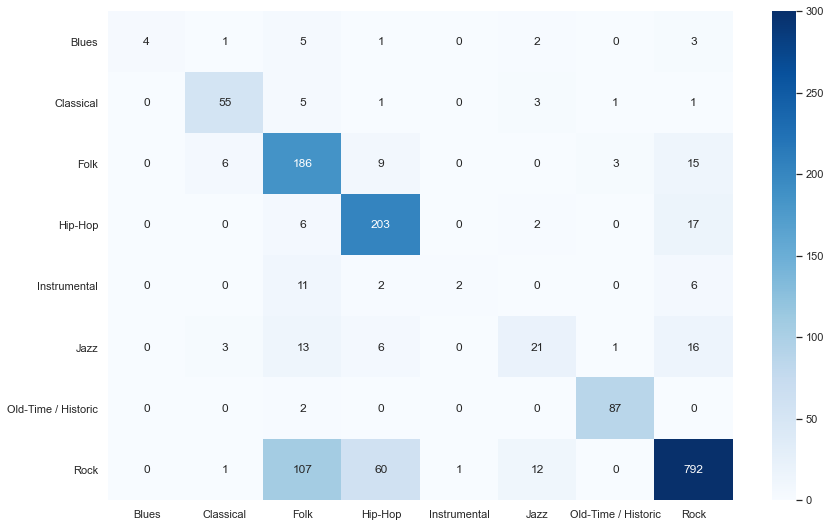

In [860]:
# Same as model one but with less min_samples_*

model_3 = test_scaling_2(
             #tracks_with_extra_audio_features_df, 
             extra_audio_genre_df,
             RobustScaler, 
             pca_components=None, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [16, 20, 24],
                'n_estimators': [750, 850], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [2,4, 6],
                'min_samples_leaf': [4,6, 8, 10],
        #        'ccp_alpha': [0.001],
        #        'oob_score': [True]
             },
             cv_splits=5
        )

mode.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 24, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 750}


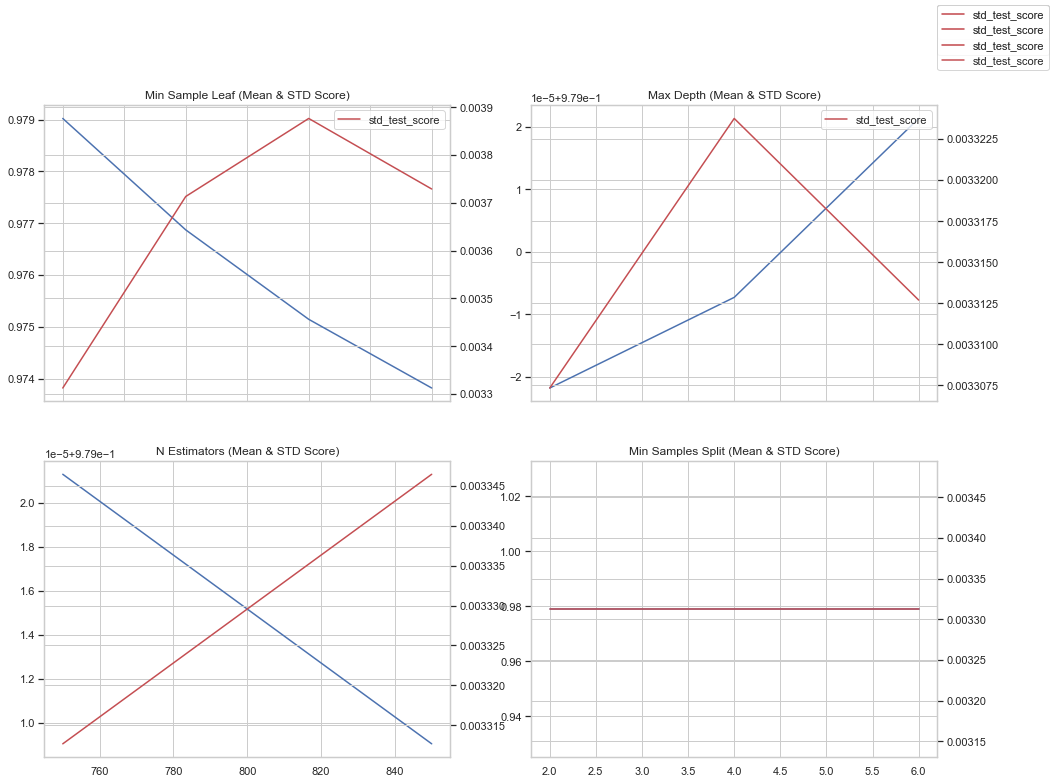

model.param_grid
{'max_depth': [16, 20, 24], 'n_estimators': [750, 850], 'class_weight': ['balanced_subsample'], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [4, 6, 8, 10]}
model.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 24, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 750}


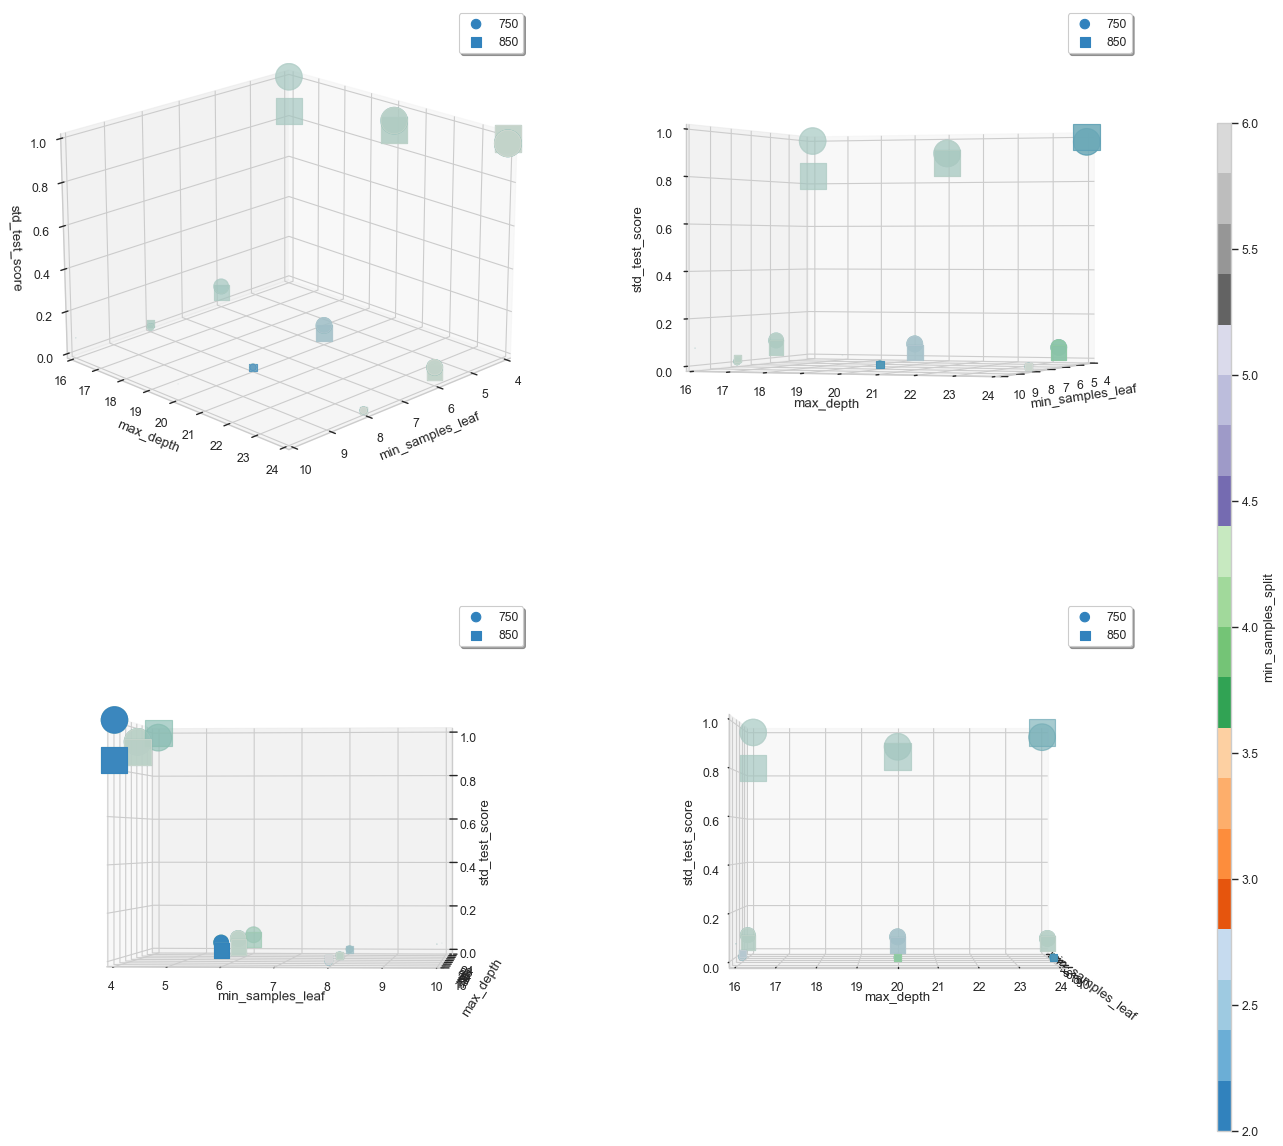

In [862]:
graph_training(model_3[0])
make_3d_plots(model_3[0])

In [5]:
# Changing Scaler Strategy

(4139, 447) (4139,)
(1672, 447) (1672,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 51.9min finished


Training time: 3152.679468154907s
accuracy: 0.8026315789473685
f1_score: 0.6438910738658554
precision: 0.763836634706549
recall: 0.6380501296814209
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.31      0.48        16
          Classical       0.81      0.85      0.83        66
               Folk       0.56      0.84      0.67       219
            Hip-Hop       0.70      0.89      0.78       228
       Instrumental       0.67      0.10      0.17        21
               Jazz       0.50      0.33      0.40        60
Old-Time / Historic       0.95      0.98      0.96        89
               Rock       0.93      0.81      0.87       973

           accuracy                           0.80      1672
          macro avg       0.76      0.64      0.64      1672
       weighted avg       0.83     

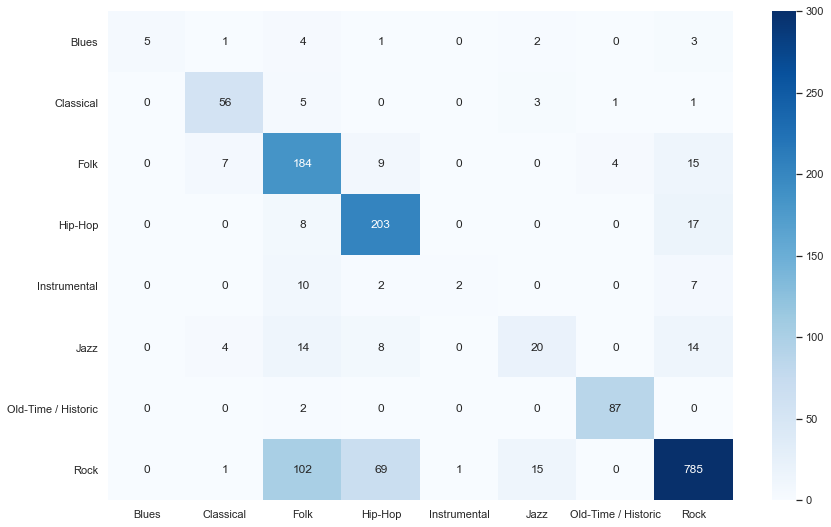

In [30]:
(model_7, pca_7, X_train_7, _X_train_7) = test_scaling_2(
             tracks_with_extra_audio_features_df, 
             MinMaxScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [12,16, 20],
                'n_estimators': [700, 850, 1000], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6],
                'min_samples_leaf': [6,12,16,20,24],
                'oob_score': [True]
             },
             cv_splits=5
        )

mode.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


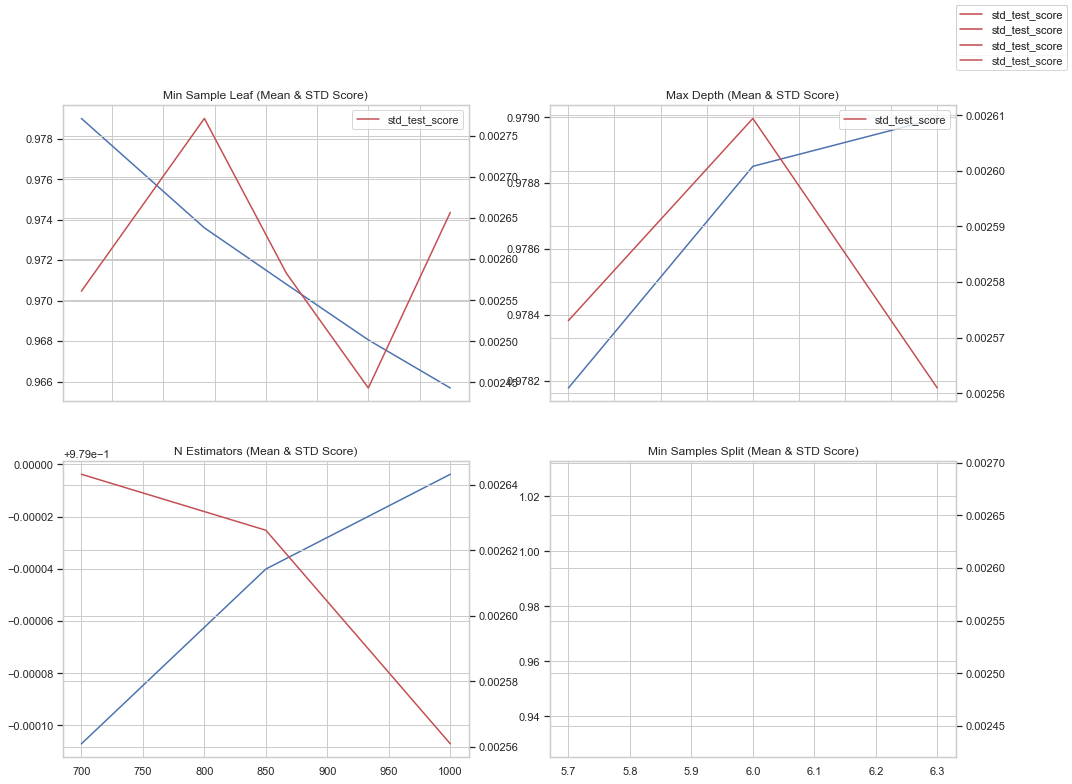

model.param_grid
{'max_depth': [12, 16, 20], 'n_estimators': [700, 850, 1000], 'class_weight': ['balanced_subsample'], 'min_samples_split': [6], 'min_samples_leaf': [6, 12, 16, 20, 24], 'oob_score': [True]}
model.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


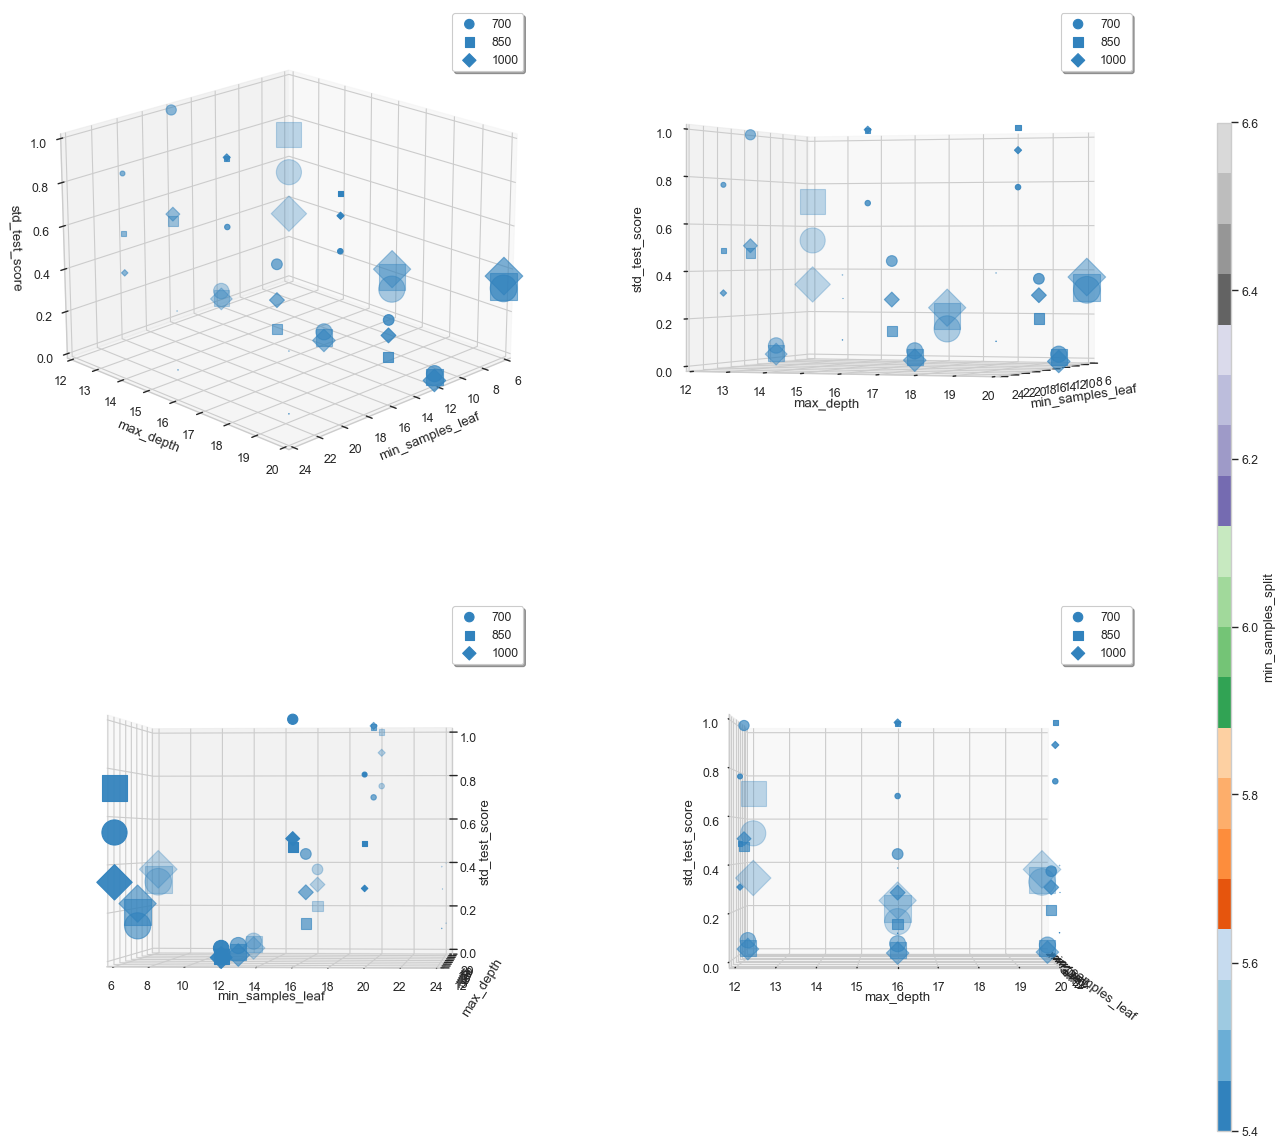

In [846]:
graph_training(model_7)
make_3d_plots(model_7)

(4139, 447) (4139,)
(1672, 447) (1672,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.5s remaining:   54.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.3s finished


Training time: 87.20764207839966s
accuracy: 0.7876794258373205
f1_score: 0.6780529851740789
precision: 0.7317499204277758
recall: 0.6793817305726759
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 850, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.44      0.61        16
          Classical       0.75      0.88      0.81        66
               Folk       0.55      0.81      0.66       219
            Hip-Hop       0.67      0.89      0.76       228
       Instrumental       0.60      0.29      0.39        21
               Jazz       0.43      0.38      0.41        60
Old-Time / Historic       0.91      0.98      0.94        89
               Rock       0.94      0.78      0.85       973

           accuracy                           0.79      1672
          macro avg       0.73      0.68      0.68      1672
       weighted avg       0.82    

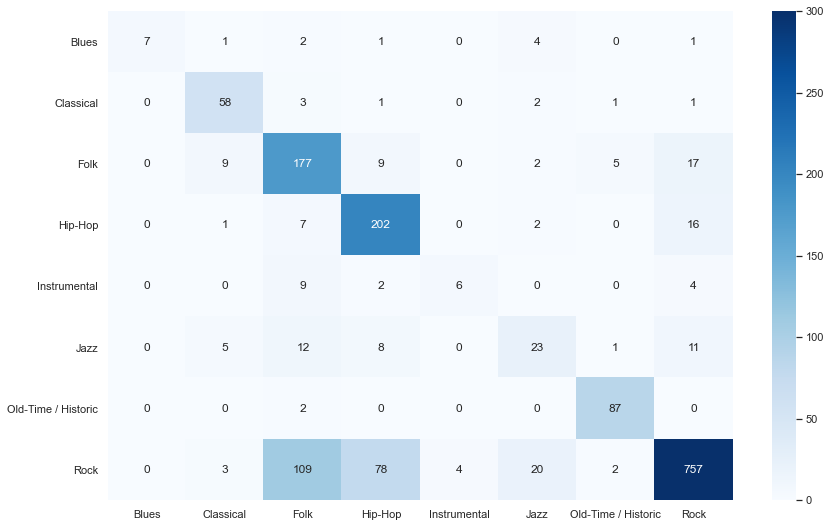

In [262]:
# Model_2 With tune params, only Standar Scaling
(model_5, pca_5, X_train_5, _X_train_5) = test_scaling_2(
             tracks_with_extra_audio_features_df, 
             StandardScaler,
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [16],
                'n_estimators': [850], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6],
                'min_samples_leaf': [12],
                'oob_score': [True]
             },
             cv_splits=5
        )

(4139, 447) (4139,)
(1672, 447) (1672,)
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 24.0min finished


Training time: 1484.549262046814s
accuracy: 0.80622009569378
f1_score: 0.6337854691504913
precision: 0.7802029823170232
recall: 0.6253223131004271
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.19      0.32        16
          Classical       0.80      0.83      0.81        66
               Folk       0.56      0.82      0.66       219
            Hip-Hop       0.71      0.89      0.79       228
       Instrumental       0.75      0.14      0.24        21
               Jazz       0.56      0.33      0.42        60
Old-Time / Historic       0.95      0.98      0.96        89
               Rock       0.93      0.82      0.87       973

           accuracy                           0.81      1672
          macro avg       0.78      0.63      0.63      1672
       weighted avg       0.83      

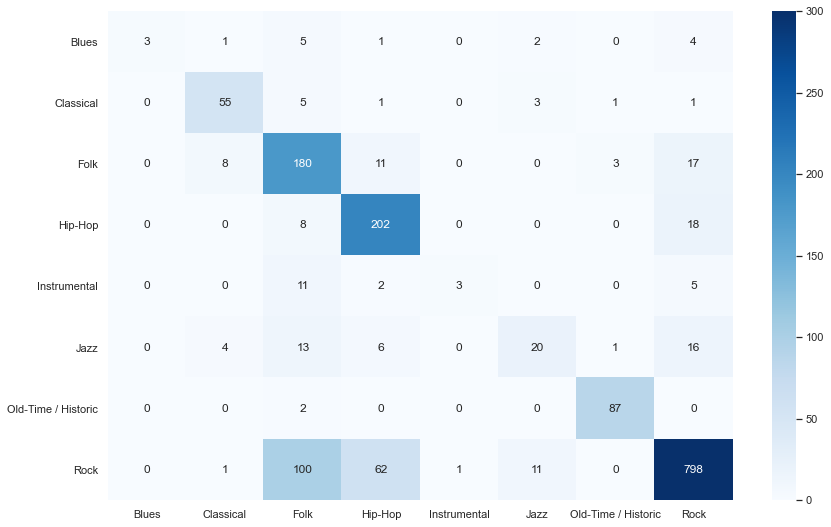

In [886]:
# Same as model three but with OOB True
#tracks_with_extra_audio_features_df
model_4 = test_scaling_2(
             extra_audio_genre_df, 
             RobustScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [10, 16, 20, 24],
                'n_estimators': [750, 850, 1000], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6],
                'min_samples_leaf': [4,6, 8, 10],
        #        'ccp_alpha': [0.001],
                'oob_score': [True]
             },
             cv_splits=5
        )

mode.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


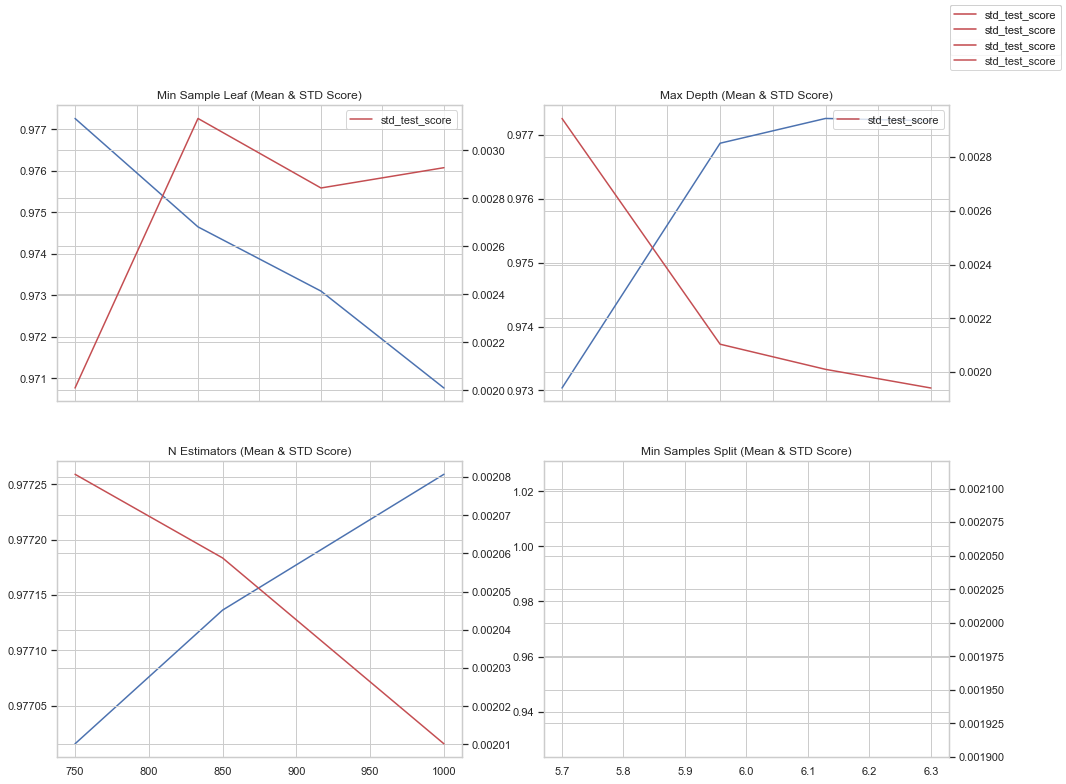

model.param_grid
{'max_depth': [10, 16, 20, 24], 'n_estimators': [750, 850, 1000], 'class_weight': ['balanced_subsample'], 'min_samples_split': [6], 'min_samples_leaf': [4, 6, 8, 10], 'oob_score': [True]}
model.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


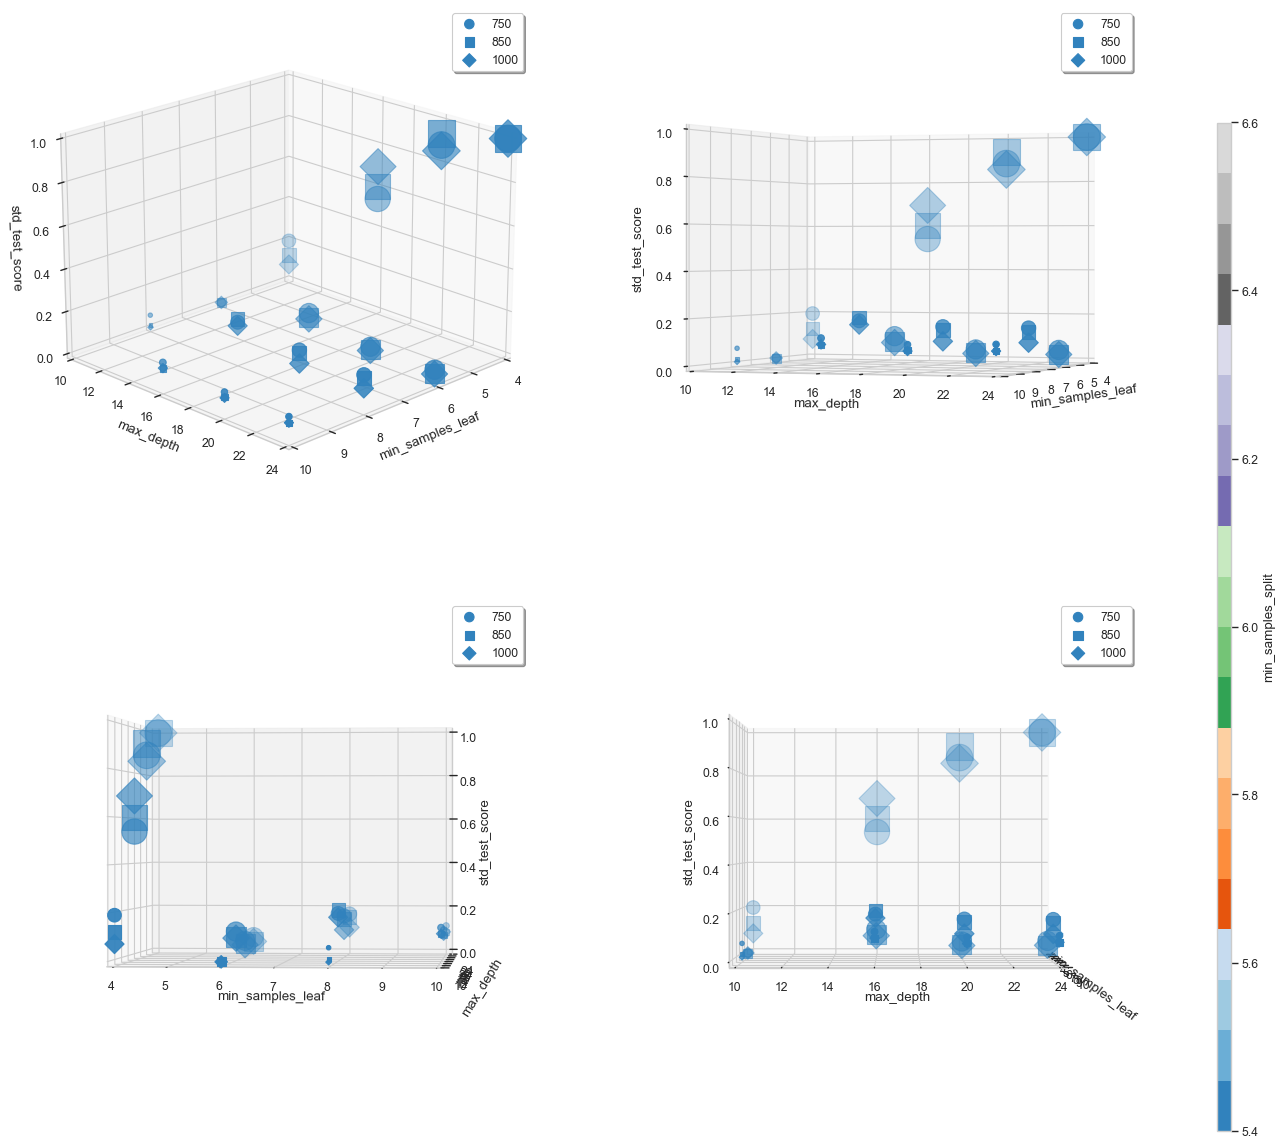

In [887]:
graph_training( model_4[0])
make_3d_plots(model_4[0])

(4139, 181) (4139,)
(1672, 181) (1672,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.1s remaining:   46.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished


Training time: 68.96327209472656s
accuracy: 0.77811004784689
f1_score: 0.6411772390790587
precision: 0.7761563730516322
recall: 0.6353838077382921
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 850, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.31      0.48        16
          Classical       0.74      0.80      0.77        66
               Folk       0.54      0.73      0.62       219
            Hip-Hop       0.65      0.91      0.76       228
       Instrumental       1.00      0.19      0.32        21
               Jazz       0.52      0.37      0.43        60
Old-Time / Historic       0.84      0.99      0.91        89
               Rock       0.92      0.78      0.84       973

           accuracy                           0.78      1672
          macro avg       0.78      0.64      0.64      1672
       weighted avg       0.81      

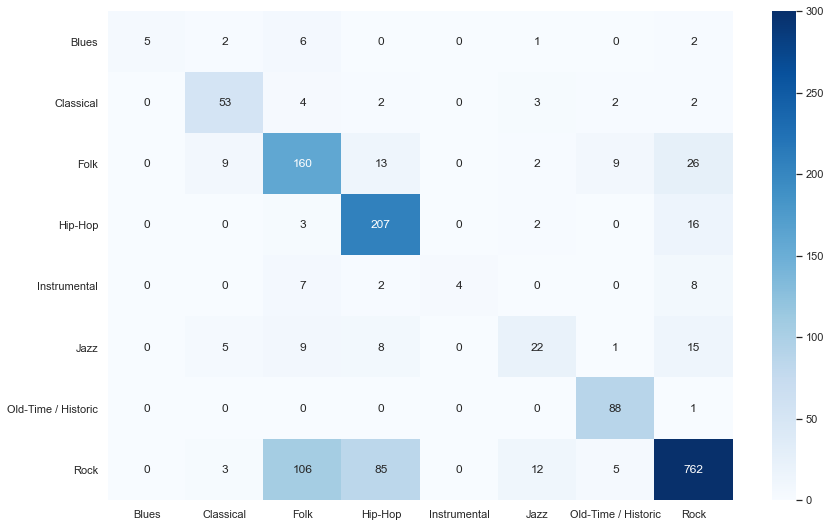

In [263]:
# Model 5 with Standard Scaler + PCA 
(model_8, pca_8, X_train_8, _X_train_8) = test_scaling_2(
             tracks_with_extra_audio_features_df, 
             StandardScaler,
             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [16],
                'n_estimators': [850], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6],
                'min_samples_leaf': [12],
                'oob_score': [True]
             },
             cv_splits=5
        )

(4139, 447) (4139,)
(1672, 447) (1672,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.1s finished


Training time: 91.67544388771057s
accuracy: 0.7870813397129187
f1_score: 0.6528880517440836
precision: 0.7466384899051566
recall: 0.65215646987963
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 850, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.38      0.55        16
          Classical       0.77      0.85      0.81        66
               Folk       0.55      0.77      0.64       219
            Hip-Hop       0.69      0.90      0.78       228
       Instrumental       0.80      0.19      0.31        21
               Jazz       0.34      0.37      0.35        60
Old-Time / Historic       0.89      0.98      0.93        89
               Rock       0.93      0.79      0.85       973

           accuracy                           0.79      1672
          macro avg       0.75      0.65      0.65      1672
       weighted avg       0.82      

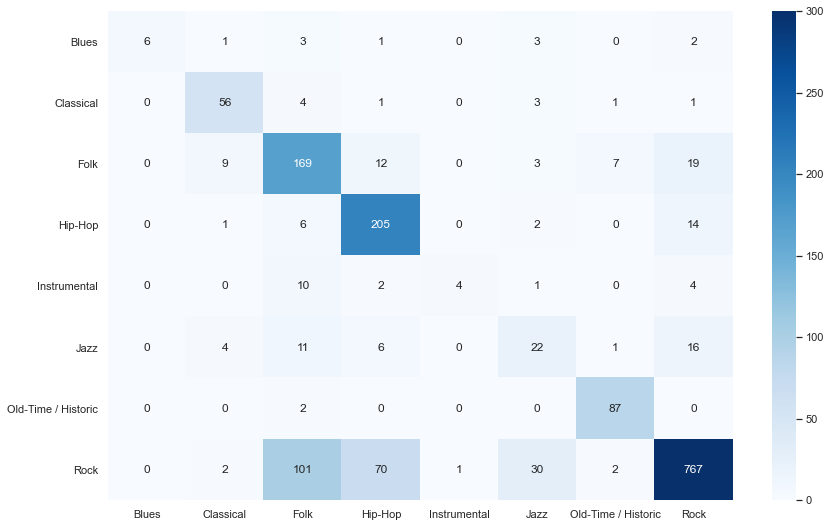

In [264]:
# Model 5 with MinMax Scaler

(model_6, pca_6, X_train_6, _X_train_6) = test_scaling_2(
             tracks_with_extra_audio_features_df, 
             MinMaxScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [16],
                'n_estimators': [850], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6],
                'min_samples_leaf': [12],
                'oob_score': [True]
             },
             cv_splits=5
        )

(4139, 129) (4139,)
(1672, 129) (1672,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 15.1min finished


Training time: 947.4680740833282s
accuracy: 0.7787081339712919
f1_score: 0.5841703658428765
precision: 0.7624492522795083
recall: 0.588753299758792
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.06      0.12        16
          Classical       0.86      0.85      0.85        66
               Folk       0.53      0.80      0.64       219
            Hip-Hop       0.63      0.86      0.73       228
       Instrumental       0.50      0.05      0.09        21
               Jazz       0.73      0.32      0.44        60
Old-Time / Historic       0.94      0.99      0.96        89
               Rock       0.91      0.79      0.84       973

           accuracy                           0.78      1672
          macro avg       0.76      0.59      0.58      1672
       weighted avg       0.81     

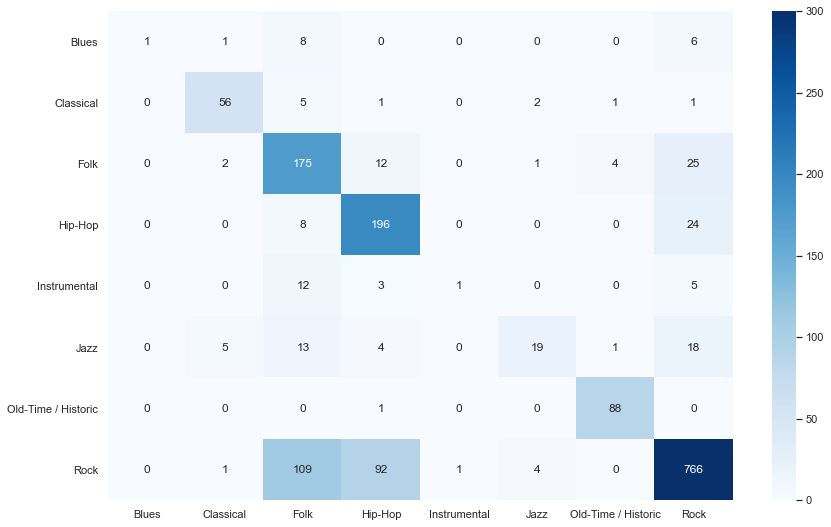

In [269]:
(model_8, pca_8, X_train_8, _X_test_8) = test_scaling_2(
             tracks_with_extra_audio_features_df, 
             MinMaxScaler, 
             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [12,16, 20],
                'n_estimators': [700, 850, 1000], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6],
                'min_samples_leaf': [6,12,16,20,24],
                'oob_score': [True]
             },
             cv_splits=5
        )

mode.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


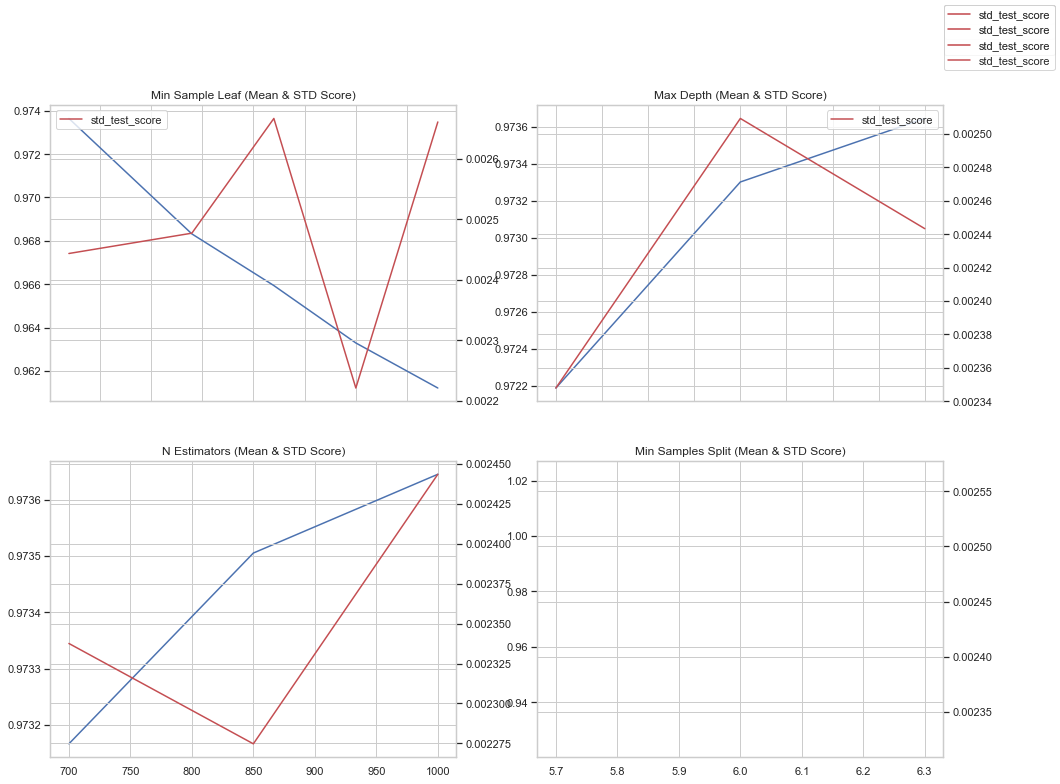

model.param_grid
{'max_depth': [12, 16, 20], 'n_estimators': [700, 850, 1000], 'class_weight': ['balanced_subsample'], 'min_samples_split': [6], 'min_samples_leaf': [6, 12, 16, 20, 24], 'oob_score': [True]}
model.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


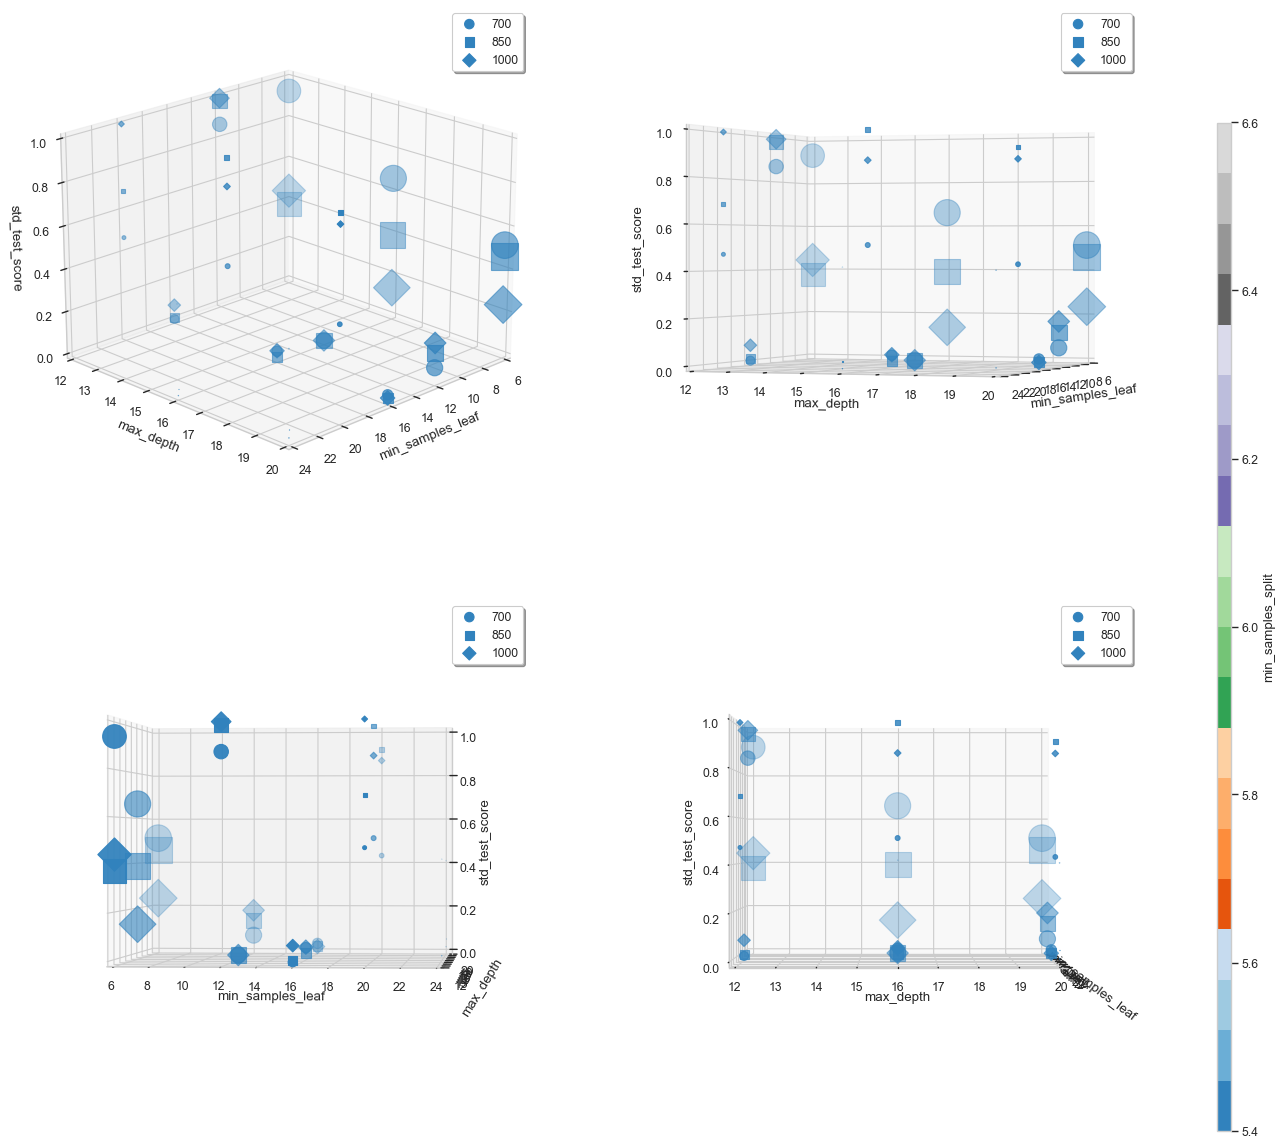

In [845]:
graph_training(model_8)
make_3d_plots(model_8)

In [273]:
# Conseguir buenos ejemplares de Blues, Jazz e Instrumental para añadir al test de entrenamiento.

extra_audio_derived_genre_df.head()

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
236           0.230013      0.848918  0.444921          0.820067  0.162606   
461           0.984355      0.571168  0.319628          0.030623  0.567914   
462           0.983755      0.648854  0.273137          0.258233  0.665152   
463           0.987198      0.694961  0.309419          0.340356  0.102491   
464           0.978804      0.618105  0.381706          0.609562  0.100077   

          speechiness    tempo   valence   genre_top  duration  \
track_id                                                         
236          0.101744  120.095  0.846313  Electronic       309   
461          0.050290  107.232  0.788501       Blues       328   
462          0.033117  115.764  0.517182       Blues       323   
463          0.039797  115.397  0.554299       Blues       224   
464          0.067830  114.829  0.622699       Blues       397   

          chroma_cens_kur_1  chroma_cens_kur_2  chroma_cens_kur_3  \
track_id                                                            
236                0.843553          -0.006805           0.853572   
461               -0.232402          -0.513834          -0.631902   
462               -0.673546          -0.381609          -0.761070   
463                0.176040          -0.600774          -0.847070   
464                0.084367           0.239588          -0.534009   

          chroma_cens_kur_4  chroma_cens_kur_5  chroma_cens_kur_6  \
track_id                                                            
236               -0.188404           0.635823           0.445843   
461               -0.587899          -0.750615          -0.305911   
462               -0.584683          -0.460692          -0.606037   
463               -0.523820          -0.534542          -0.346340   
464                0.336015           0.153693          -0.089140   

          chroma_cens_kur_7  chroma_cens_kur_8  chroma_cens_kur_9  \
track_id                                                            
236                0.054466           0.034797           2.077905   
461               -0.464886          -0.476020          -0.341977   
462               -0.297484          -0.688570          -0.647130   
463               -0.607133          -0.377977          -0.749118   
464                0.003948           0.257749          -0.112415   

          chroma_cens_kur_10  chroma_cens_kur_11  chroma_cens_kur_12  \
track_id                                                               
236                 1.607494            0.462250            0.022049   
461                 0.417287           -0.289005           -0.432215   
462                -0.774999           -0.020674           -0.864919   
463                -0.225314           -0.480595           -0.043282   
464                -0.035142           -0.064238            0.013120   

          chroma_cens_mea_1  chroma_cens_mea_2  chroma_cens_mea_3  \
track_id                                                            
236                0.234016           0.205640           0.188927   
461                0.211369           0.254761           0.332208   
462                0.296861           0.251047           0.228849   
463                0.191797           0.213118           0.258972   
464                0.237610           0.270490           0.298402   

          chroma_cens_mea_4  chroma_cens_mea_5  chroma_cens_mea_6  \
track_id                                                            
236                0.203411           0.248382           0.246269   
461                0.336216           0.294553           0.254343   
462                0.291322           0.311474           0.264483   
463                0.286507           0.302079           0.277561   
464                0.314563           0.351335           0.323735   

          chroma_cens_mea_7  chroma_cens_mea_8  chroma_cens_mea_9  \
track_

In [1252]:
_mask = extra_audio_derived_genre_df.genre_top.isin(['Jazz', 'Blues', 'Instrumental', 'Rock'])
extra_audio_derived_genre_df[_mask].genre_top.value_counts()

Rock            400
Jazz            306
Blues           140
Instrumental     51
Name: genre_top, dtype: int64

In [1478]:
# Same as model four best but with derived songs

undersampling_ratio =  {
        'International': 100,
        'Blues': 50,
        'Jazz': 181,
        'Classical': 199,
        'Old-Time / Historic': 268,
        'Pop': 259,
        'Rock': 1200,
        'Electronic': 1600,
        'Folk': 655,
        'Hip-Hop': 682,
        'Experimental': 13,
        'Instrumental': 63
    }
oversampling_ratio = {
        'International': 200,
        'Blues': 150,
        'Jazz': 600,
        'Classical': 399,
        'Old-Time / Historic': 470,
        'Pop': 450,
        'Rock': 1200,
        'Electronic': 1600,
        'Folk': 750,
        'Hip-Hop': 750,
        'Experimental': 50,
        'Instrumental': 110
    }

(5270, 447)
(5540, 447)
(4280, 447) (4280,)
(1672, 447) (1672,)
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.2min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.3min remaining:   34.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


Training time: 127.27219676971436s
accuracy: 0.8175837320574163
f1_score: 0.6443296856606947
precision: 0.8155190887891985
recall: 0.6329051240532304
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.25      0.40        16
          Classical       0.86      0.83      0.85        66
               Folk       0.59      0.84      0.69       219
            Hip-Hop       0.73      0.89      0.80       228
       Instrumental       1.00      0.10      0.17        21
               Jazz       0.47      0.35      0.40        60
Old-Time / Historic       0.96      0.98      0.97        89
               Rock       0.93      0.84      0.88       973

           accuracy                           0.82      1672
          macro avg       0.82      0.63      0.64      1672
       weighted avg       0.84   

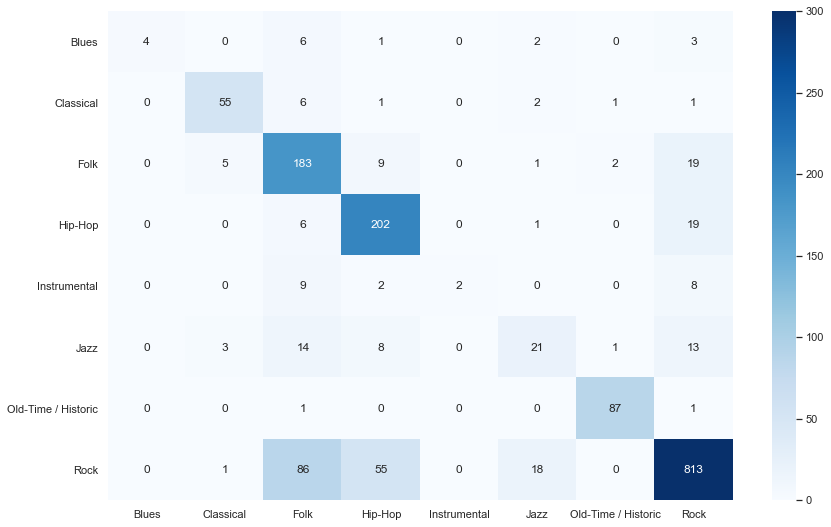

In [547]:
#Model 4 tuned, Con 90 random samples de Jazz
model_9 = test_scaling_2(
             extra_audio_genre_df, 
             RobustScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [20],
                'n_estimators': [1000], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6],
                'min_samples_leaf': [2, 4],
        #        'ccp_alpha': [0.001],
                'oob_score': [True]
             },
             cv_splits=5,
             undersampling_ratio=undersampling_ratio,
             oversampling_ratio=oversampling_ratio,
             extra_oversampler_data=extra_audio_derived_genre_df[_mask],
             verbose=False
        )

In [1467]:
_model = model_9[1]

accuracy_score(model_9[1][1], model_9[0].best_estimator_.predict(model_9[1][0]))

(5270, 447)
(5540, 447)
(4280, 447) (4280,)
(1672, 447) (1672,)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 71.7min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 104.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 133.0min finished


Training time: 8029.656061172485s
accuracy: 0.8205741626794258
f1_score: 0.6269598414663364
precision: 0.8240982129582791
recall: 0.6173811523233961
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.12      0.22        16
          Classical       0.90      0.85      0.88        66
               Folk       0.59      0.83      0.69       219
            Hip-Hop       0.75      0.87      0.80       228
       Instrumental       1.00      0.10      0.17        21
               Jazz       0.48      0.35      0.40        60
Old-Time / Historic       0.96      0.98      0.97        89
               Rock       0.92      0.85      0.88       973

           accuracy                           0.82      1672
          macro avg       0.82      0.62      0.63      1672
       weighted avg       0.84    

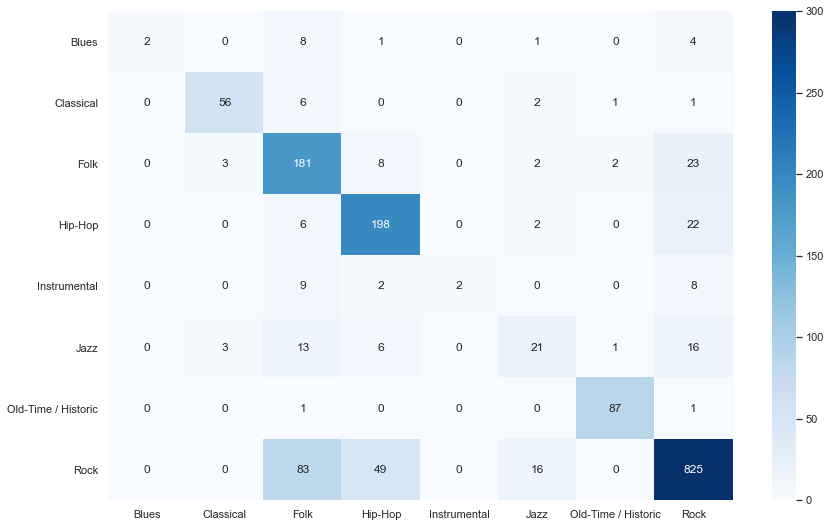

In [590]:
#Model 4 tuned, Con extra random data
model_10 = test_scaling_2(
             extra_audio_genre_df, 
             RobustScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [10, 16, 20, 24],
                'n_estimators': [800, 850, 900, 1000], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [2, 6, 10],
                'min_samples_leaf': [2,4,6, 8, 10, 12],
        #        'ccp_alpha': [0.001],
                'oob_score': [True]
             },
             cv_splits=5,
             undersampling_ratio=undersampling_ratio,
             oversampling_ratio=oversampling_ratio,
             extra_oversampler_data=extra_audio_derived_genre_df[_mask],
             verbose=False
        )

mode.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'oob_score': True}


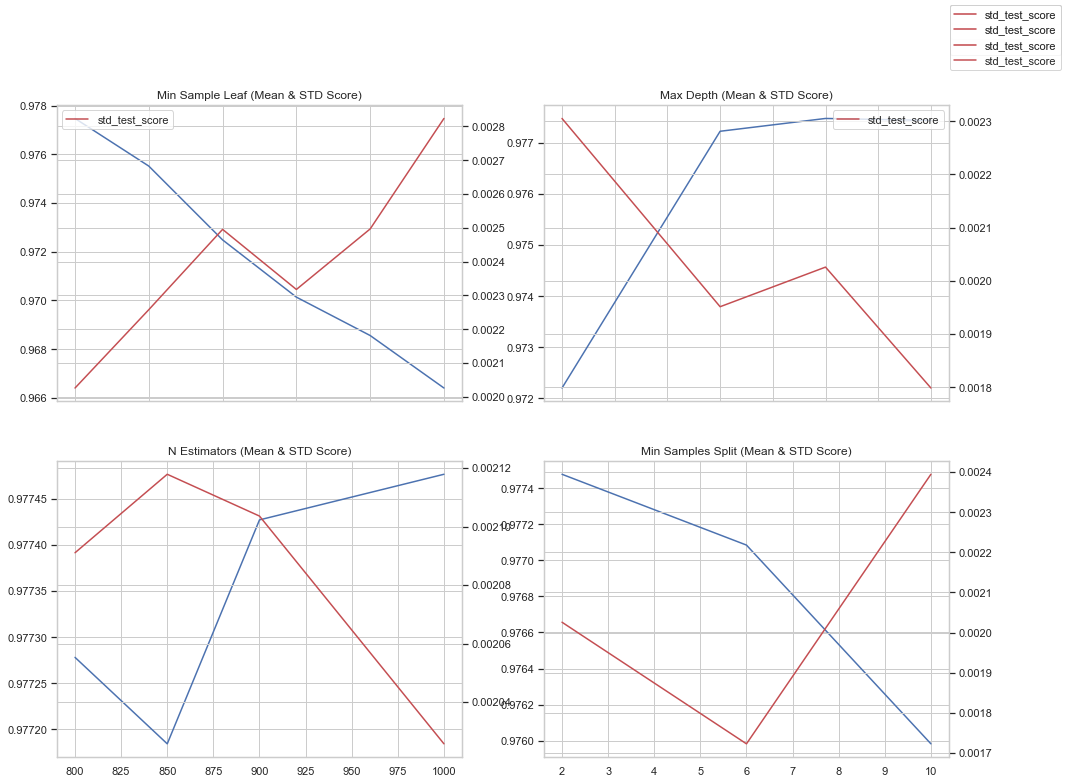

model.param_grid
{'max_depth': [10, 16, 20, 24], 'n_estimators': [800, 850, 900, 1000], 'class_weight': ['balanced_subsample'], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [2, 4, 6, 8, 10, 12], 'oob_score': [True]}
model.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'oob_score': True}


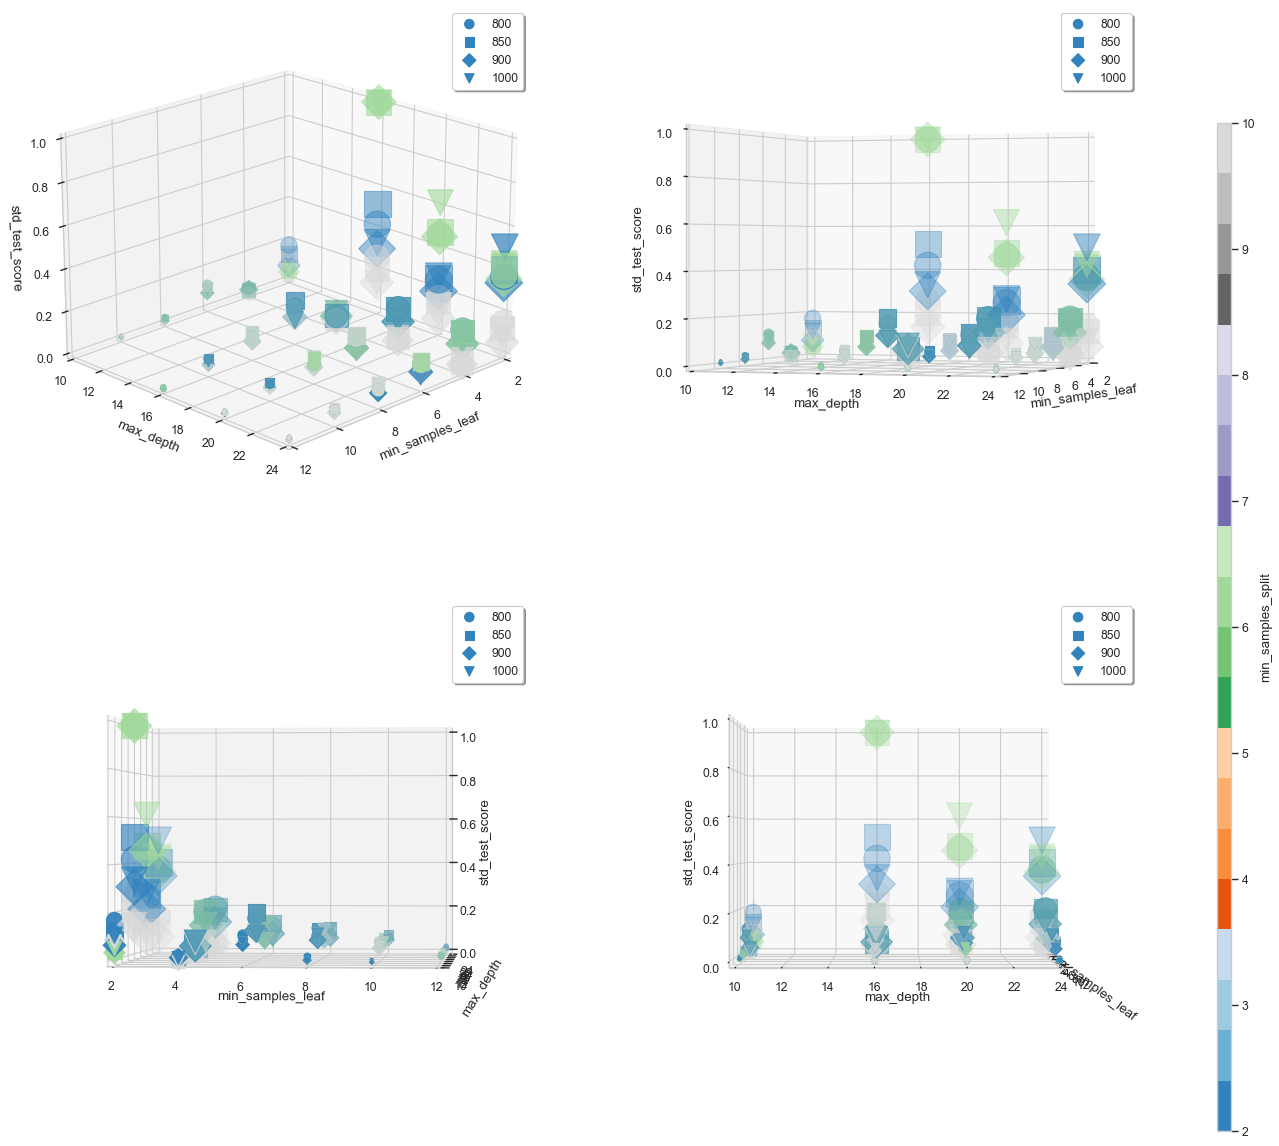

In [852]:
graph_training(model_10[0])
make_3d_plots(model_10[0])

(4429, 447) (4429,)
(1672, 447) (1672,)
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 91.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 114.5min finished


Training time: 6930.153566122055s
accuracy: 0.8074162679425837
f1_score: 0.6435859366903425
precision: 0.755451279612787
recall: 0.638193576240291
{'class_weight': 'balanced_subsample', 'max_depth': 24, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.31      0.48        16
          Classical       0.82      0.83      0.83        66
               Folk       0.58      0.82      0.68       219
            Hip-Hop       0.73      0.88      0.80       228
       Instrumental       0.67      0.10      0.17        21
               Jazz       0.37      0.37      0.37        60
Old-Time / Historic       0.95      0.98      0.96        89
               Rock       0.93      0.82      0.87       973

           accuracy                           0.81      1672
          macro avg       0.76      0.64      0.64      1672
       weighted avg       0.83      

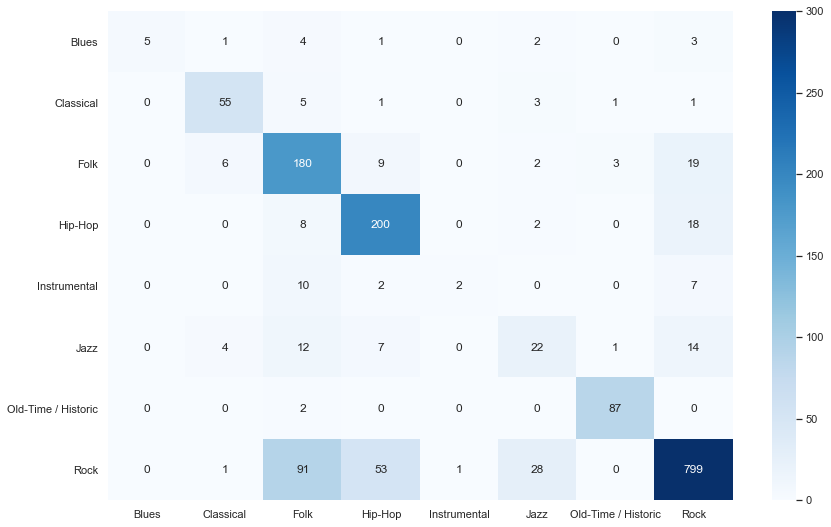

In [1481]:
# Same as model four best but with derived songs

undersampling_ratio =  {
        'International': 100,
        'Blues': 50,
        'Jazz': 181,
        'Classical': 199,
        'Old-Time / Historic': 268,
        'Pop': 259,
        'Rock': 1200,
        'Electronic': 1600,
        'Folk': 655,
        'Hip-Hop': 682,
        'Experimental': 13,
        'Instrumental': 63
    }
oversampling_ratio = {
        'International': 200,
        'Blues': 150,
        'Jazz': 600,
        'Classical': 399,
        'Old-Time / Historic': 470,
        'Pop': 450,
        'Rock': 1200,
        'Electronic': 1600,
        'Folk': 750,
        'Hip-Hop': 750,
        'Experimental': 50,
        'Instrumental': 110
    }

#Model 4 tuned, Con 90 random samples de Jazz
model_9_test = test_scaling_2(
             extra_audio_genre_df, 
             RobustScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [6, 12, 16, 24],
                'n_estimators': [400, 600, 800, 1000], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6, 12, 20],
                'min_samples_leaf': [4, 12, 24],
        #        'ccp_alpha': [0.001],
                'oob_score': [True]
             },
             cv_splits=5,
             undersampling_ratio=undersampling_ratio,
             oversampling_ratio=oversampling_ratio,
             extra_oversampler_data=extra_audio_derived_genre_df[_mask],
             verbose=False
        )

mode.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 24, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


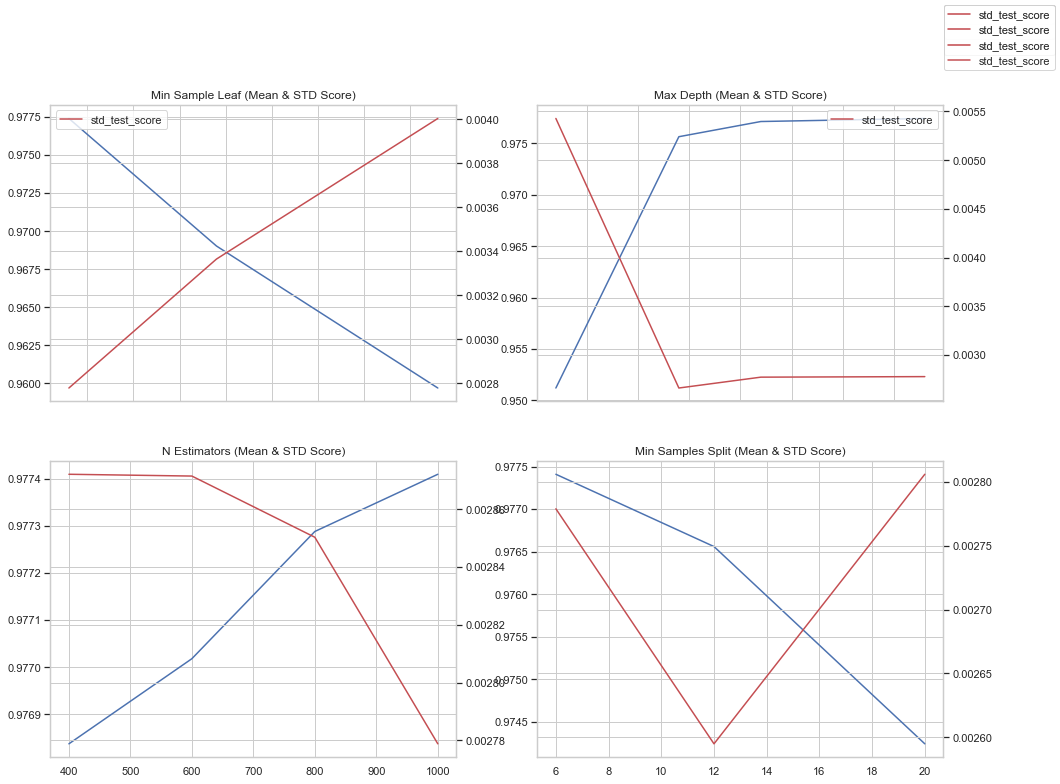

model.param_grid
{'max_depth': [6, 12, 16, 24], 'n_estimators': [400, 600, 800, 1000], 'class_weight': ['balanced_subsample'], 'min_samples_split': [6, 12, 20], 'min_samples_leaf': [4, 12, 24], 'oob_score': [True]}
model.best_params_
{'class_weight': 'balanced_subsample', 'max_depth': 24, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}


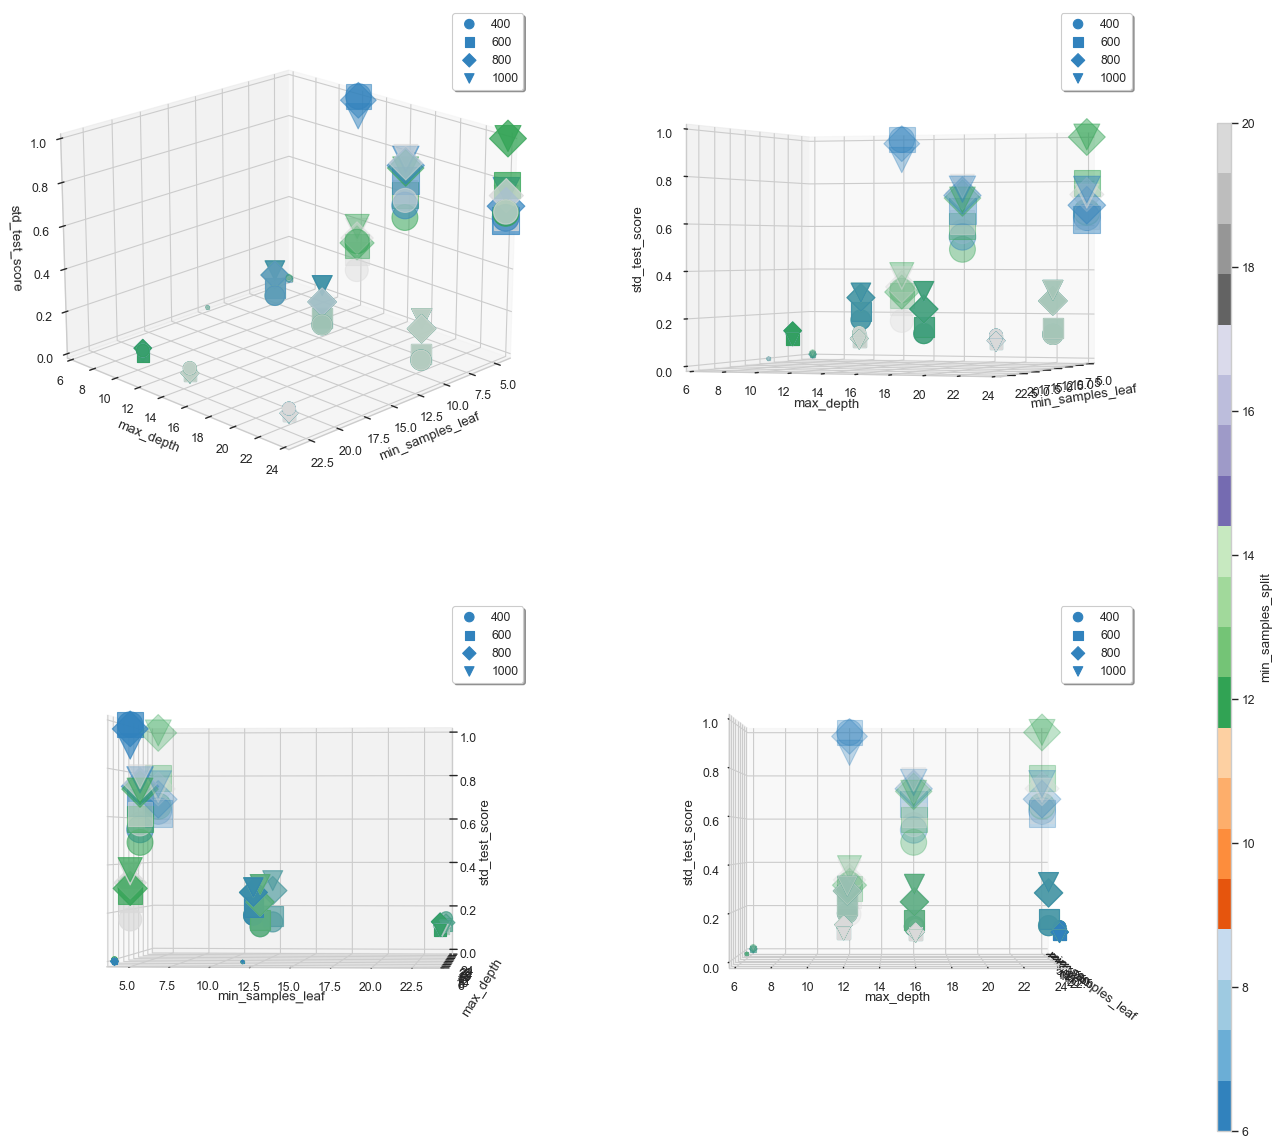

In [1497]:
graph_training(model_9_test[0])
make_3d_plots(model_9_test[0])

In [1470]:
extra_audio_derived_genre_df.shape

(3774, 10)

In [591]:
f, ax = pyplot.subplots(figsize=(16, 100))

features = model_9[2].columns
importances = model_9[0].best_estimator_.feature_importances_
indices = np.argsort(importances)

pyplot.title('Feature Importances')
pyplot.barh(range(len(indices)), importances[indices], color='b', align='center')
pyplot.yticks(range(len(indices)), [features[i] for i in indices])
pyplot.xlabel('Relative Importance')
pyplot.show()

In [844]:
def graph_training(model):
    results = pd.DataFrame(model.cv_results_)
    
    fig, axs = pyplot.subplots(2, 2, figsize=(16, 12))

    print("mode.best_params_")
    print(model.best_params_)
    
    mask = (results.param_n_estimators == model.best_params_['n_estimators']) & \
           (results.param_min_samples_split == model.best_params_['min_samples_split']) & \
           (results.param_max_depth == model.best_params_['max_depth'])
    
    axs[0, 0].set_title('Min Sample Leaf (Mean & STD Score)')
    axs[0,0].plot(results[mask].param_min_samples_leaf, results[mask].mean_test_score)    
    ax2 = axs[0,0].twinx()
    results[mask].plot(x="param_min_samples_leaf", y="std_test_score", ax=ax2, color="r")
    axs[0,0].figure.legend()
    
    mask = (results.param_n_estimators == model.best_params_['n_estimators']) & \
           (results.param_min_samples_split == model.best_params_['min_samples_split']) & \
           (results.param_min_samples_leaf == model.best_params_['min_samples_leaf'])
    axs[0, 1].set_title('Max Depth (Mean & STD Score)')
    axs[0,1].plot(results[mask].param_max_depth, results[mask].mean_test_score)
    ax2 = axs[0,1].twinx()
    results[mask].plot(x="param_max_depth", y="std_test_score", ax=ax2, color="r")
    axs[0,1].figure.legend()

    mask = (results.param_max_depth == model.best_params_['max_depth']) & \
           (results.param_min_samples_split == model.best_params_['min_samples_split']) & \
           (results.param_min_samples_leaf == model.best_params_['min_samples_leaf'])
    axs[1,0].set_title('N Estimators (Mean & STD Score)')
    axs[1,0].plot(results[mask].param_n_estimators, results[mask].mean_test_score)
    ax2 = axs[1,0].twinx()
    results[mask].plot(x="param_n_estimators", y="std_test_score", ax=ax2, legend=False, color="r")
    axs[1,0].figure.legend()
    
    mask = (results.param_max_depth == model.best_params_['max_depth']) & \
           (results.param_n_estimators == model.best_params_['n_estimators']) & \
           (results.param_min_samples_leaf == model.best_params_['min_samples_leaf'])
    axs[1,1].set_title('Min Samples Split (Mean & STD Score)')    
    axs[1,1].plot(results[mask].param_min_samples_split, results[mask].mean_test_score)
    ax2 = axs[1,1].twinx()
    results[mask].plot(x="param_min_samples_split", y="std_test_score", ax=ax2, legend=False, color="r")
    axs[1,1].figure.legend()
    
    pyplot.show()
    
def make_3d_plots(model):
    results = pd.DataFrame(model.cv_results_)
    print("model.param_grid")
    print(model.param_grid)
    print("model.best_params_")
    print(model.best_params_)
    
    cmap0 = mpl.colors.LinearSegmentedColormap.from_list('green2red', ['green', 'orangered'])
    
    
    fig, axs = pyplot.subplots(2, 2, figsize=(18, 18), dpi=80, facecolor='w', edgecolor='k', subplot_kw=dict(projection='3d'))
    
    angles = [(20, 45), (0, 20), (0, -85), (0,0)]
    _ax  = None
    for ax, angle in zip(axs.flatten(), angles):
        _filter, p = plot_single_3d_2(model, results, ax, fig)    
        legend = ax.legend(loc='best', shadow=True, fancybox=True, markerscale=0.5)
        
        ax.set_xlabel('min_samples_leaf')
        ax.set_ylabel('max_depth')
        ax.set_zlabel('std_test_score')
        
        _z = increase_diff(results[_filter].std_test_score, inverse=True)
        ax.set_xlim3d(results[_filter].param_min_samples_leaf.min(), results[_filter].param_min_samples_leaf.max())
        ax.set_ylim3d(results[_filter].param_max_depth.min(), results[_filter].param_max_depth.max())
        ax.set_zlim3d(_z.min(), _z.max())
        ax.view_init(angle[0], angle[1])
        #change the marker size manually for both lines
        _ax = ax
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.7])
    cbar = fig.colorbar(p, cax=cbar_ax)
    cbar.set_label('min_samples_split')
    pyplot.show()

def plot_single_3d(
                    model, results, ax, fig,
                    clist = ['xkcd:cloudy blue', 'xkcd:dark pastel green', 'xkcd:warm purple', 'xkcd:golden yellow'],
                    col = 0,
                    markers = ['o', 's', 'D', 'v']):
    for N in model.param_grid['n_estimators']:
        c = clist[col] 
        m = markers[col]
        _filter = (results.param_n_estimators == N)
        
        _x = results[_filter][['param_min_samples_leaf']]
        _y = results[_filter][['param_max_depth']]
        _z = increase_diff(results[_filter].std_test_score, inverse=True)
        
        _min_score = results[_filter][['mean_test_score']].min()
        _max_score = results[_filter][['mean_test_score']].max()


        #_ms = (np.divide((results[_filter][['mean_test_score']] - _min_score), _max_score - _min_score) ** 2) * 240
        _ms = increase_diff(results[_filter].mean_test_score, factor = 24)
        p =ax.scatter(_x, _y, _z, c=results[_filter][['param_min_samples_split']], marker=m, label=str(N), s=_ms, cmap='tab20c')
        col += 1 
        
    return _filter, p

def increase_diff(data, factor=1, inverse=False):
    if inverse:
        data = 1 / data
    return (np.divide((data - data.min()), data.max() - data.min()) * factor) ** 2 



        

In [1496]:
def test_scaling_2(
    data, 
    scaler,
    pca_components=None, 
    random_state=7, 
    _genres_to_study = [],
    sample_weight=False,
    params={},
    cv_splits=3,
    verbose=False,
    undersampling_ratio={},
    oversampling_ratio={},
    extra_oversampler_data=None
):
    if pca_components and (scaler == RobustScaler):
        raise Exception("RobustScaler cannot be used in conjuction with PCA.")

    # Data Scaling and Split    
    data = basic_data_preparation(
        data, 
        scaler_class=scaler, 
        features=extra_audio_genre_df.drop('genre_top', axis=1).columns, 
        extra_data=extra_oversampler_data
    )
    
    # Resampling
    X_train, y_train = resampling(data['X_train'], 
                                  data['y_train'], 
                                  _undersampling_ratio=undersampling_ratio, 
                                  _oversampling_ratio=oversampling_ratio,
                                  extra_oversampler_data=data['extra_data'],
                                  verbose=verbose
                                 )
   
    X_test = data['X_test']
    y_test = data['y_test']
    
    
    # PCA 
    if pca_components:
        pca = PCA(n_components = 0.95, random_state=7)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    else:
        pca = None
    
    # Genre Filters
    if _genres_to_study:
        X_train = X_train[y_train.isin(_genres_to_study)]
        y_train = y_train[y_train.isin(_genres_to_study)]
        
        X_test = X_test[y_test.reset_index().genre_top.isin(_genres_to_study)]
        y_test = y_test[y_test.isin(_genres_to_study)].reset_index().genre_top 
                          
    # Class Weights
    sample_weights = None
    if sample_weight:
        class_weights = list(class_weight.compute_class_weight('balanced',
                                                                np.unique(y_train),
                                                                y_train
                                                              )
                            )

        w_array = np.ones(y_train.shape[0], dtype = 'float')
        for i, val in enumerate(y_train):
            w_array[i] = class_weights[_t[val]]
        print(w_array)
        sample_weights = w_array


        
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    # Agregar flag para hacer fit o para dibujar resultados (dado un model ya fiteado/instanciado)
    model = test_model_cv_grid(
        X_train, 
        y_train, 
        X_test,
        y_test, 
        RandomForestClassifier(random_state=random_state), 
        params,
        cv_splits=cv_splits, 
        score='roc_auc_ovo_weighted', 
        sample_weight=sample_weights,
        verbose=verbose
    )
    
    # Decouple Printing results from test_model_cv_grid
    # Add to results training score
    # Optional curves
    
    print(f'Training Score: {y_train, model.predict(X_train)}')
    return (model, pca, (X_train, y_train), (X_test, y_test))

    

In [1091]:
def custom_plot_confusion_matrix(confusion_matrix, genre_list=['Blues', 'Hip-Hop','Jazz', 'Pop', 'Rock'], vmax=300):
    df_cm = pd.DataFrame(confusion_matrix, index = genre_list, columns = genre_list)
    pyplot.figure(figsize = (14,9))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues", vmax=vmax)

In [1005]:
def resampling(x_train, y_train, _undersampling_ratio={}, _oversampling_ratio={}, extra_oversampler_data=None, verbose=False):
    if verbose:
        print(f'Before: {y_train.value_counts()}')
    undersampling_ratio = _undersampling_ratio if _undersampling_ratio else {
        'International': 100,
        'Blues': 50,
        'Jazz': 181,
        'Classical': 199,
        'Old-Time / Historic': 268,
        'Pop': 259,
        'Rock': 1200,
        'Electronic': 1600,
        'Folk': 655,
        'Hip-Hop': 682,
        'Experimental': 13,
        'Instrumental': 63
    }
    
    oversampling_ratio = _oversampling_ratio if _oversampling_ratio else {
        'International': 200,
        'Blues': 150,
        'Jazz': 300,
        'Classical': 399,
        'Old-Time / Historic': 470,
        'Pop': 450,
        'Rock': 1200,
        'Electronic': 1600,
        'Folk': 750,
        'Hip-Hop': 750,
        'Experimental': 50,
        'Instrumental': 120
    }

    sampler=RandomUnderSampler(sampling_strategy=undersampling_ratio)
    Xu,yu=sampler.fit_resample(x_train, y_train)
    
    if extra_oversampler_data is not None:
        Jazz_extra = extra_oversampler_data[extra_oversampler_data.genre_top == 'Jazz'].sample(120)
        extra_Jazz_x_train = Jazz_extra.drop('genre_top', axis=1)
        extra_Jazz_y_train = Jazz_extra.genre_top

        Instru_extra = extra_oversampler_data[extra_oversampler_data.genre_top == 'Instrumental'].sample(40)
        extra_Instru_x_train = Jazz_extra.drop('genre_top', axis=1)
        extra_Instru_y_train = Jazz_extra.genre_top

        Blues_extra = extra_oversampler_data[extra_oversampler_data.genre_top == 'Blues'].sample(40)
        extra_Blues_x_train = Jazz_extra.drop('genre_top', axis=1)
        extra_Blues_y_train = Jazz_extra.genre_top
    
        #print(Xu.shape)
        Xu=pd.concat([Xu, extra_Jazz_x_train, extra_Instru_x_train, extra_Blues_x_train])
        #print(Xu.shape)
        yu=pd.concat([yu, extra_Jazz_y_train, extra_Instru_y_train, extra_Blues_y_train])

    sm=RandomOverSampler(sampling_strategy=oversampling_ratio)
    _X_resampled, _y_resampled = sm.fit_resample(Xu,yu)
    if verbose:
        print(f'After: {y_train.value_counts()}')

    return (_X_resampled, _y_resampled)

In [857]:
## Prepare Train & Test Data

def basic_data_preparation(df, scaler_class=StandardScaler, features=[], extra_data=None):
    
    X = df.drop('genre_top', axis=1)
    y = df['genre_top']

    scaler = scaler_class()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)

    X_train_sc_df = pd.DataFrame(X_train, columns = features)
    X_test_sc_df = pd.DataFrame(X_test, columns = features)
    
    if extra_data is not None:
        scaled_extra_data = scaler.transform(extra_data.drop('genre_top', axis=1))
        scaled_extra_data_df = pd.DataFrame(scaled_extra_data, columns = features)
        #print(scaled_extra_data_df.tail(10))
        scaled_extra_data_df = pd.concat([scaled_extra_data_df, extra_data.genre_top.reset_index().drop('track_id', axis=1)], axis=1)
        #print(scaled_extra_data_df.tail(10))
    return {
        "X_train": X_train_sc_df,
        "y_train": y_train,
        "X_test":  X_test_sc_df,
        "y_test":  y_test,
        "extra_data": scaled_extra_data_df if extra_data is not None else None
    }

In [1220]:
def pick_rows_alike(
    data, 
    extra, 
    genre, 
    quantity=-1, 
    tol=0.000001, 
    tol_step=-1, 
    importances=[], 
    original_sample=10
):    
    
    """
    Strategies:
    - Naive:  First encounter, goes to the bag, up to finish `orignal_tracks_sample` rows 
              or to hit required `quantity` if set, whatver happens first.
    - Greedy: all that can fit into the tolerance differences, `quantity` is ignored, a 
              warming will be raised if it is set.
    - Random: First classify all that fit tolerances, later choose existing qualified 
              rows up to `quantity`.
    - Top:    First classify all rows and order them descending by score and choose the 
              `quantity` top rows.
    - Auto: ***
    """
    
    # Sanity Checks
    # both datasets need to have same amount of columns with comparable 
    
    # Calcular la tolerancia calculando el valor promedio (corregido STD/Median)
    # de la muestra tomada contra su propio dataset orignal
    
    orignal_rows_sample = data[data.genre_top == genre].sample(original_sample)
    extra_filtered =  extra[extra.genre_top == genre]
    chosen_indices = [] 

    #Top
    
    compairson_df = pd.DataFrame([],columns = ['original_index', 'derived_index', 'score'])
    for original_index, original_track in orignal_rows_sample.sample(original_sample).iterrows():
        for derived_index, derived_track in extra_filtered.iterrows():
            ed = Euclidean_Dist(original_track.drop('genre_top'), derived_track.drop('genre_top'), importances)
            chosen_indices.append((original_index, derived_index, ed))
        compairson_df = pd.concat([compairson_df, pd.DataFrame(chosen_indices, columns = ['original_index', 'derived_index', 'score'])])
        # compute score per each row un extra, and save (indices, score) in sorted order (desc)
        # nxet track
    
    return compairson_df
    # sort by score, and choose Top Quantity
    # Return indexes
    # Noise Index (sum all differences / mean / std) (if feasible :'))
    

In [1274]:
jazz_extra_ids = pick_rows_alike(
    extra_audio_genre_df,
    extra_audio_derived_genre_df[_mask],
    "Jazz",
    original_sample=100,
    importances = importances
)

print(jazz_extra_ids[jazz_extra_ids.score < 2].sort_values(by='score').shape)

(7601, 3)


In [1273]:
blues_extra_ids = pick_rows_alike(
    extra_audio_genre_df,
    extra_audio_derived_genre_df[_mask],
    "Blues",
    original_sample=10,
    importances = importances
)

print(blues_extra_ids[blues_extra_ids.score < 2].sort_values(by='score').shape)

instru_extra_ids = pick_rows_alike(
    extra_audio_genre_df,
    extra_audio_derived_genre_df[_mask],
    "Instrumental",
    original_sample=10,
    importances = importances
)

print(instru_extra_ids[instru_extra_ids.score < 2].sort_values(by='score').shape)

(26, 3)
(62, 3)
(17, 3)


In [1227]:
# Custom Distance
def compare_two_rows(row1, row2, importances=None):
    k = -1
    if importances is not None:
        np.sum(np.absolute(row1 - row2) * (1/importances)) / len(importances)
    else:
        k = np.sum(np.absolute(np.array(row1) - np.array(row2)))
    return k

In [1053]:
scaler = StandardScaler()
_d1 = scaler.fit_transform(extra_audio_genre_df.drop('genre_top', axis=1))
_d2 = scaler.fit_transform(extra_audio_derived_genre_df[_mask].drop('genre_top', axis=1))

jazz1 = _d1[0]
jazz2 = _d2[0]

In [1054]:
s = compare_two_rows(jazz1, jazz2,)

s

/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


-1

In [1055]:
importances =  model_4[0].best_estimator_.feature_importances_

In [586]:
importances[importances == 0] = np.finfo(float).eps

In [1147]:
def Euclidean_Dist(row1, row2, importances = None, cols=['x_coord','y_coord']):
    row1 = np.array(row1)
    row2 = np.array(row2) 
    
    if importances is not None:
        row1 = row1 * importances
        row2 = row2 * importances
    
    return np.linalg.norm(row1 - row2)

In [1257]:
# Test Euclidean Distance

jazz_1 = extra_audio_genre_df[extra_audio_genre_df.genre_top == 'Jazz'].head(1).drop(['genre_top'], axis=1)
jazz_3 = extra_audio_genre_df[extra_audio_genre_df.genre_top == 'Jazz'].head(2).drop(['genre_top'], axis=1).iloc[1]
print(len(jazz_1.columns))

jazz_2 = extra_audio_derived_genre_df[extra_audio_derived_genre_df.genre_top == 'Jazz'].head(1).drop(['genre_top'], axis=1)
print(len(jazz_2.columns))

rock_1 = extra_audio_derived_genre_df[extra_audio_derived_genre_df.genre_top == 'Rock'].head(1).drop(['genre_top'], axis=1)
print(len(jazz_2.columns))

print(Euclidean_Dist(jazz_1, jazz_2, importances))
print(Euclidean_Dist(jazz_1, jazz_1, importances))
print(Euclidean_Dist(jazz_1, rock_1, importances))

print(Euclidean_Dist(jazz_1, jazz_2))
print(Euclidean_Dist(jazz_1, jazz_1))
print(Euclidean_Dist(jazz_1, rock_1))

447
447
447
5.733868939684963
1.6966954238687133
0.0
12.16697938177461
1029.0834007016495
0.0
2733.6077419006206


In [1089]:
models = [model, model_1[0], model_2[0], model_3[0], model_4[0], model_7, model_8, model_10[0]]

(4139, 447) (4139,)
(1672, 447) (1672,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   58.5s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.0s finished


Training time: 134.62762117385864s
accuracy: 0.7948564593301436
f1_score: 0.6681695308042537
precision: 0.745434676242778
recall: 0.6639975760380465
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}
                     precision    recall  f1-score   support

              Blues       1.00      0.44      0.61        16
          Classical       0.79      0.86      0.83        66
               Folk       0.56      0.80      0.66       219
            Hip-Hop       0.67      0.89      0.77       228
       Instrumental       0.67      0.19      0.30        21
               Jazz       0.43      0.35      0.39        60
Old-Time / Historic       0.91      0.98      0.94        89
               Rock       0.94      0.79      0.86       973

           accuracy                           0.79      1672
          macro avg       0.75      0.66      0.67      1672
       weighted avg       0.82   

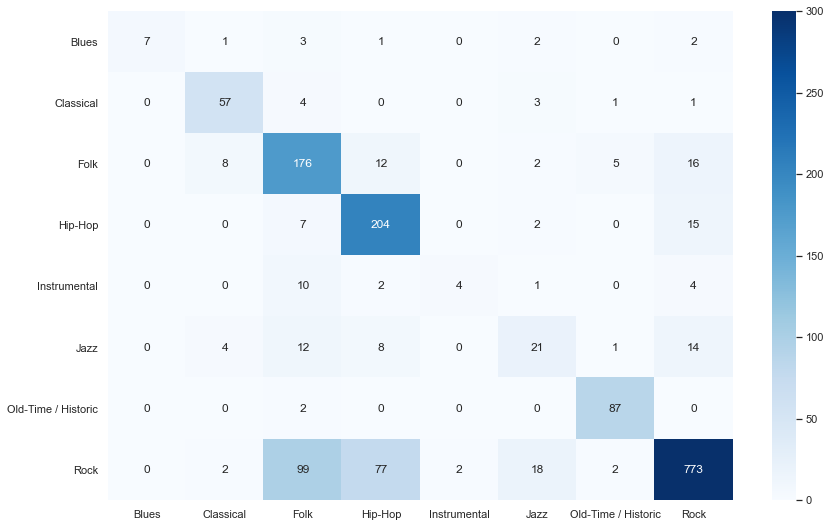

In [1008]:
{'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 1000, 'oob_score': True}

#Model 4 tuned, Con extra random data
model_2_for_validation = test_scaling_2(
             extra_audio_genre_df, 
             RobustScaler, 
#             pca_components=0.95, 
             _genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic'],
             sample_weight = False,         
             params = {
                'max_depth': [16],
                'n_estimators': [1000], 
                'class_weight': ['balanced_subsample'],
                'min_samples_split': [6],
                'min_samples_leaf': [10],
        #        'ccp_alpha': [0.001],
                'oob_score': [True]
             },
             cv_splits=5,
#             undersampling_ratio=undersampling_ratio,
#             oversampling_ratio=oversampling_ratio,
#             extra_oversampler_data=extra_audio_derived_genre_df[_mask],
             verbose=False
        )

In [1010]:
model_2_val[3][1]

0                      Rock
1                      Rock
2                      Rock
3                      Rock
4                      Rock
               ...         
1667                   Folk
1668                   Rock
1669    Old-Time / Historic
1670                   Rock
1671                Hip-Hop
Name: genre_top, Length: 1672, dtype: category
Categories (16, object): [Blues, Classical, Country, Easy Listening, ..., Pop, Rock, Soul-RnB, Spoken]

(1672, 447) (1672,)
(1672, 447) (1672,)
(852, 447) (852,)
                     precision    recall  f1-score   support

              Blues       1.00      0.44      0.61        16
          Classical       0.80      0.86      0.83        66
               Folk       0.72      0.81      0.76       200
            Hip-Hop       0.83      0.89      0.86       200
       Instrumental       1.00      0.19      0.32        21
               Jazz       0.62      0.35      0.45        60
Old-Time / Historic       0.93      0.98      0.95        89
               Rock       0.77      0.78      0.77       200

           accuracy                           0.79       852
          macro avg       0.83      0.66      0.69       852
       weighted avg       0.79      0.79      0.78       852



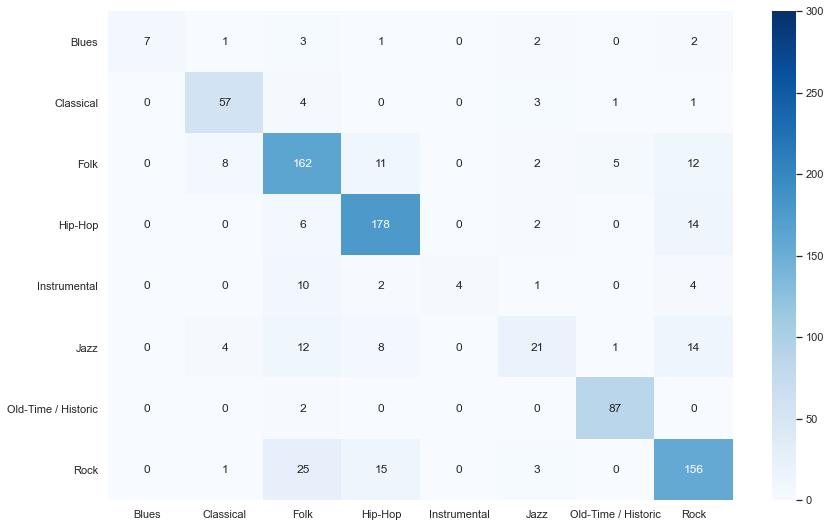

In [1043]:
genres_to_study=['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic']

__model = model_2_val[0].best_estimator_
X_test = model_2_val[3][0].reset_index().drop('index', axis=1)
y_test = model_2_val[3][1]

print(X_test.shape, y_test.shape)
print(X_test.shape, y_test.shape)

balanced_random_validation_set_ids = []

sample = 200
for genre in genres_to_study:
    subset = y_test[y_test == genre]
    balanced_random_validation_set_ids += list(subset.sample(min(sample, len(subset))).index)

X_validation = X_test[X_test.index.isin(balanced_random_validation_set_ids)]
y_validation = y_test[y_test.index.isin(balanced_random_validation_set_ids)]

print(X_validation.shape, y_validation.shape)

oredered_genres = list(y_validation.unique())
oredered_genres.sort()
y_pred = __model.predict(X_validation)
print(classification_report(y_validation, y_pred))

cm = confusion_matrix(y_validation, y_pred)
custom_plot_confusion_matrix(cm, genre_list=oredered_genres)

In [1044]:
# crear mejores datasets
# refitear modelos ya pre-entrenados
# tomar medidas antes y despues de accuracy, f1, recall y precision (weighted & macro)

# Gráficos: Metrica por cada model, con dataset antes y despues

In [1322]:
# TensorFlow Classifier

import tensorflow as tf

x_train, y_train = model_2_val[2]
x_test, y_test = model_2_val[3]

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(x_train)

classifier_tf = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns, 
                                               hidden_units=[120, 75, 35, 20], 
                                               n_classes=14)

classifier_tf.fit(x_train, y_train_num, steps=3000)

predictions = list(classifier_tf.predict(x_test, as_iterable=True))

score = metrics.accuracy_score(y_test_num, predictions)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa1d79f2cd0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/79/53km5r152bg8j9g60yb9qh0w0000gn/T/tmptj5lwqak'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done

In [1306]:
#y_train_num = tf.convert_to_tensor(y_train.cat.codes, dtype=tf.int32)

#y_test_num = tf.convert_to_tensor(y_test.cat.codes, dtype=np.int32)

#y_train_num = tf.dtypes.cast(y_test.cat.codes.astype('np.int32'), tf.int32)

#y_test_num = tf.dtypes.cast(y_test.cat.codes.astype('np.int32'), tf.int32)


y_train_num = y_train.cat.codes.astype('int32')
y_test_num = y_test.cat.codes.astype('int32')

In [1353]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(np.array(y_train).reshape(-1,1))
print(enc.categories_)

y_train_ohe = enc.transform(np.array(y_train).reshape(-1,1))

y_test_ohe = enc.transform(np.array(y_test).reshape(-1,1))

y_train_ohe.todense()

[array(['Blues', 'Classical', 'Folk', 'Hip-Hop', 'Instrumental', 'Jazz',
       'Old-Time / Historic', 'Rock'], dtype=object)]


matrix([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]])

In [1363]:
from keras.utils import to_categorical

y_train_le = to_categorical(y_train.cat.codes)
y_test_le = to_categorical(y_test.cat.codes)

len(y_train_le[0])

14

In [1324]:
score

0.8086124401913876

              precision    recall  f1-score   support

           0       0.57      0.25      0.35        16
           1       0.83      0.79      0.81        66
           6       0.59      0.75      0.66       219
           7       0.80      0.87      0.83       228
           8       0.24      0.19      0.21        21
          10       0.40      0.47      0.43        60
          11       0.98      0.98      0.98        89
          13       0.90      0.84      0.87       973

    accuracy                           0.81      1672
   macro avg       0.66      0.64      0.64      1672
weighted avg       0.82      0.81      0.81      1672



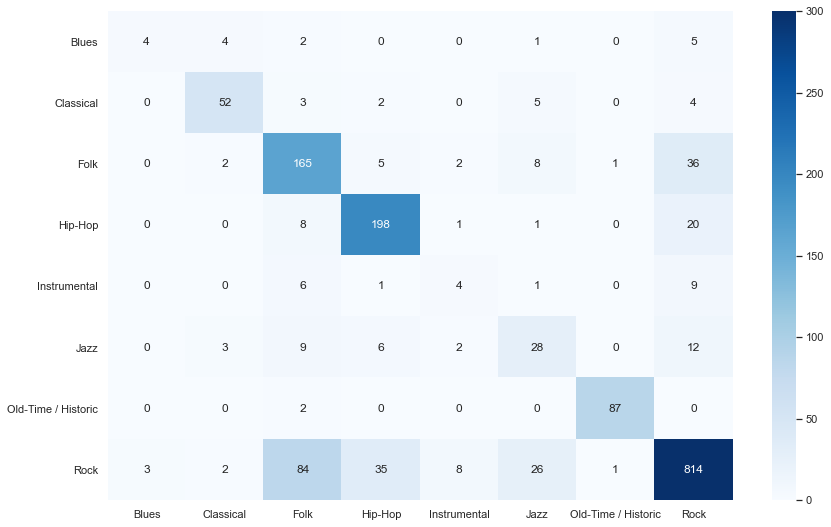

In [1323]:
print(classification_report(y_test_num, predictions))

cm = confusion_matrix(y_test_num, predictions)

custom_plot_confusion_matrix(cm, genre_list=oredered_genres)

In [1498]:
os.environ["KERAS_BACKEND"] = ""

os.environ["RUNFILES_DIR"] = ""
# plaidml might exist in different location. Look for "/usr/local/share/plaidml" and replace in above path

os.environ["PLAIDML_NATIVE_PATH"] = ""